## Import statements

In [46]:
library(BBmisc)
library(bnlearn)
library(penalized)
library(rbmn)
library(repr)

## 1. Function to input datasets

In [178]:
read_data <- function(unitname, filename, normalize=FALSE){
    input <- read.delim(paste("C:/Users/abhig/OneDrive/Documents/#COURSES/#MTP/data/", filename, "_", unitname,".txt", sep=""))
    input$X <- NULL
    if(unitname == "mixer" || unitname == "reactor"){
        colnames(input)[4] = "R5"
    }
    if(unitname==""){
        input <- cbind(input,R5=rep(input$F5))
    }
    if(normalize){
        return (BBmisc::normalize(input))
    }
    else{
        return (input)
    }
}

## 2. Function to plot the graph

In [179]:
plot_graph <- function(dag){
    par(cex=0.07)
    options(repr.plot.width=3, repr.plot.height=3)
    hlight <- list(nodes = nodes(dag), arcs = arcs(dag), col = "black", textCol = "black", fill ='lightblue', lwd = 2)
    graphviz.plot(dag, highlight = hlight)    
}

In [231]:
ALI <- function(structure, filename){
#     gbn.rbmn <- bnfit2nbn(structure)
#     gema.rbmn <- nbn2gema(gbn.rbmn)
#     mn.rbmn <- gema2mn(gema.rbmn)
    set.seed(filename)
    y3 <- sample(1:10, 1)
    xrange <- seq(0,959)
    yrange <- c(rep.int(0,160+y3),rep.int(1,800-y3))
    message("Fault Occured at ", 160+y3)
    x3 <- sample(0:160+y3,y3)
    if(length(x3)>1){
        for (i in x3){
            yrange[i] <- 1
        }
    }
    else{
        yrange[x3] <- 1
    }
    plot(xrange, yrange, main="Abnormal Likelihood Index", xlab="sample", ylab="ALI")
}

## 3. Function to fit linear gaussian model

In [4]:
gaussian <- function(dag, data, verbose=FALSE){  
    print(modelstring(dag))
    est.para <- bn.fit(dag, data)
    if(verbose){
        print(est.para)
    }
    return(est.para)
}

## 4. Function to obtain Bayesian Contribution Index value

In [228]:
BCI <- function(structure, file_name, t0, tf){    
    gbn.rbmn <- bnfit2nbn(structure)
    gema.rbmn <- nbn2gema(gbn.rbmn)
    mn.rbmn <- gema2mn(gema.rbmn)
    data = read_data("", file_name)
    var = names(data)
    T = seq(t0-tf, t0+tf)
    T_length = 2*tf
    bci = data.frame(matrix(ncol = 23, nrow = 1))
    colnames(bci) <- var
    for (node in var){
        sum_gamma = 0
        for (time in T){
            node_val = data[time,node]
            parents = unlist((gbn.rbmn)[[node]]["parents"], use.names=FALSE)
            if (length(parents) == 0){
                parents = "L12"
            }
            mu = condi4joint(mn.rbmn, par = node, pour = parents, x2 = unlist(data[time,parents], use.names=FALSE))$"mu"
            gamma = condi4joint(mn.rbmn, par = node, pour = parents, x2 = unlist(data[time,parents], use.names=FALSE))$"gamma"
            if (node_val < mu){
                lower_bound = node_val
                upper_bound = 2*mu - node_val
            }
            else{
                upper_bound = node_val
                lower_bound = 2*mu - node_val
            }
            gamma = integrate(dnorm, mean=mu, sd=sqrt(gamma), lower= lower_bound, upper= upper_bound, abs.tol = 0)$value
            sum_gamma = sum_gamma + gamma
        }
        bci[1, node] <- 1/T_length * sum_gamma
    }
    return (bci)
}

## 5. Function to create barplots of BCI values

In [83]:
BCI_plot <- function(bci){    
    H <- unlist(bci, use.names=FALSE)
    M <- names(bci)
    par(cex.axis=0.9)
    # Plot the bar chart 
    options(repr.plot.width = 11, repr.plot.height = 6)
    barplot(H,names.arg=M,xlab="Variables",ylab="BCI",ylim=c(0,1),col="#001E97",main="Bayesian Contribution index",border="red", fg="#001E97", col.axis ="#FF0000")
}

<hr>

<span style="color:red"><font size="6"><b>BN Structure...</b></font></span>

<hr>

<span style="color:purple"><font size="5"><b>[Given] Given Structure as per Paper</b></font></span>

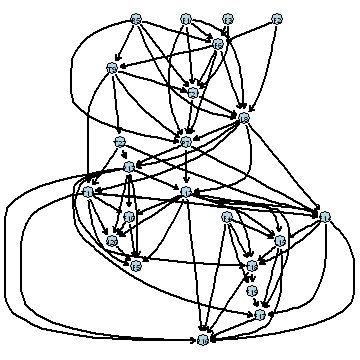

In [181]:
total1 = model2network("[F1][F2][F3][R5][T21|F1:F6:R5:F3:T9][T9|R5:F6][P7|F1:R5:F6:L8:T9:T21][L8|F1:F2:R5:F6:T21][F6|F1:F2:F3:R5][T22|T9][T11|T22:T9:L8][L12|P7:L8:P13][P13|P7:L8:T22][F14|P7:L8:L12:T22:T11][F4][L15|F14:F4:T11:L12][P16|T11:L12:P13:F14:F4:L15:F17:T18][F17|L12:P13:F14:L15:F19][T18|L12:P13:F14:L15:F4][F19|F4:T18][F10|L12:P13:T11][J20|F10:L12:P13:T11][F5|J20:F10:L12:P13:T11]")
plot_graph(total1)

### [Given] Fitting it into linear gaussian model.

In [182]:
gaussian_total1 <- gaussian(total1, read_data("", "data0"))

[1] "[F1][F2][F3][F4][R5][F6|F1:F2:F3:R5][T9|F6:R5][T21|F1:F3:F6:R5:T9][T22|T9][L8|F1:F2:F6:R5:T21][P7|F1:F6:L8:R5:T21:T9][T11|L8:T22:T9][P13|L8:P7:T22][L12|L8:P13:P7][F10|L12:P13:T11][F14|L12:L8:P7:T11:T22][J20|F10:L12:P13:T11][L15|F14:F4:L12:T11][F5|F10:J20:L12:P13:T11][T18|F14:F4:L12:L15:P13][F19|F4:T18][F17|F14:F19:L12:L15:P13][P16|F14:F17:F4:L12:L15:P13:T11:T18]"


### [Given] Describing Gaussian model by its local distribution

In [197]:
gbn.rbmn <- bnfit2nbn(gaussian_total1)
print8nbn(gbn.rbmn)

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

=====Nodes===[parents]   = Exp. (sd.dev)       
-----------------------------------------------
--------F1---[-]  = 0.267  (0.006)
--------F2---[-]  = 3655.692  (18.79)
--------F3---[-]  = 4442.585  (25.027)
--------F4---[-]  = 9.239  (0.053)
--------R5---[-]  = 32.429  (0.202)
--------F6---[F1,F2,F3,R5]  = 46.322 + 0.669*F1 + 0*F2 + 0*F3 + 0.038*R5  (0.21)
--------T9---[F6,R5]  = 123.035 + -0.002*F6 + -0.001*R5  (0.011)
-------T21---[F1,F3,F6,R5,T9]  = 125.261 + -0.06*F1 + 0*F3 + -0.005*F6 + -0.002*R5 + -0.191*T9  (0.02)
-------T22---[T9]  = -165.766 + 2.1*T9  (0.149)
--------L8---[F1,F2,F6,R5,T21]  = 120.071 + 1.307*F1 + 0.001*F2 + -0.101*F6 + 0.072*R5 + -0.537*T21  (0.506)
--------P7---[F1,F6,L8,R5,T21,T9]  = 2868.922 + -28.862*F1 + -0.135*F6 + 0.057*L8 + -0.083*R5 + -4.835*T21 + 3.577*T9  (0.983)
-------T11---[L8,T22,T9]  = 5.655 + 0.006*L8 + 0.241*T22 + 0.518*T9  (0.06)
-------P13---[L8,P7,T22]  = 180.271 + 0.012*L8 + 0.884*P7 + 0.517*T22  (0.434)
-------L12---[L8,P13,P7]  = -74.8

<hr>

<span style="color:green"><font size="5"><b>[Obtained] Obtained Structure by combining above subparts</b></font></span>

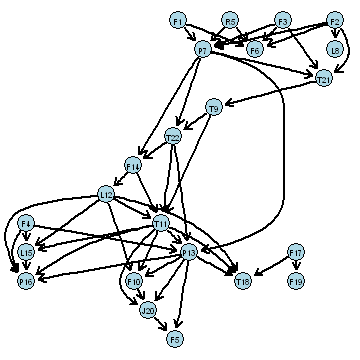

In [184]:
total2 = model2network("[F1][F2][F3][R5][F4][F17][F6|F1:F2:F3:R5][P7|F1:F2:F3:R5][L8|F2][T21|F2:F3:P7][T9|T21][T22|T9:P7][F14|P7:T22][L12|F14][T11|T9:T22:L12:F14][P13|F4:T11:P7:T22][F19|F17][L15|T11:L12:F4][T18|T11:L12:P13:F17][P16|T11:L12:P13:F4:L15][F10|T11:L12:P13][J20|T11:P13:F10][F5|P13:J20]")
plot_graph(total2)

### [Obtained] Fitting both into linear gaussian model.

In [185]:
gaussian_total2 <- gaussian(total2, read_data("", "data0"))

[1] "[F1][F17][F2][F3][F4][R5][F19|F17][F6|F1:F2:F3:R5][L8|F2][P7|F1:F2:F3:R5][T21|F2:F3:P7][T9|T21][T22|P7:T9][F14|P7:T22][L12|F14][T11|F14:L12:T22:T9][L15|F4:L12:T11][P13|F4:P7:T11:T22][F10|L12:P13:T11][P16|F4:L12:L15:P13:T11][T18|F17:L12:P13:T11][J20|F10:P13:T11][F5|J20:P13]"


### [Obtained] Describing Gaussian model by its local distribution

In [186]:
gbn.rbmn <- bnfit2nbn(gaussian_total2)
print8nbn(gbn.rbmn)

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

=====Nodes===[parents]   = Exp. (sd.dev)       
-----------------------------------------------
--------F1---[-]  = 0.267  (0.006)
-------F17---[-]  = 22.891  (0.112)
-------F19---[F17]  = 8.167 + -0.357*F17  (1.126)
--------F2---[-]  = 3655.692  (18.79)
--------F3---[-]  = 4442.585  (25.027)
--------F4---[-]  = 9.239  (0.053)
--------L8---[F2]  = 62.424 + 0.001*F2  (0.506)
--------R5---[-]  = 32.429  (0.202)
--------F6---[F1,F2,F3,R5]  = 46.322 + 0.669*F1 + 0*F2 + 0*F3 + 0.038*R5  (0.21)
--------P7---[F1,F2,F3,R5]  = 2823.932 + -29.73*F1 + -0.005*F2 + 0.001*F3 + -0.087*R5  (0.983)
-------T21---[F2,F3,P7]  = 109.762 + 0*F2 + 0*F3 + -0.003*P7  (0.019)
--------T9---[T21]  = 127.902 + -0.049*T21  (0.011)
-------T22---[P7,T9]  = -219.69 + 0.025*P7 + 1.977*T9  (0.147)
-------F14---[P7,T22]  = 35.727 + -0.003*P7 + -0.018*T22  (0.131)
-------L12---[F14]  = 46.632 + 0.132*F14  (1.026)
-------T11---[F14,L12,T22,T9]  = 4.323 + -0.006*F14 + -0.004*L12 + 0.241*T22 + 0.535*T9  (0.06)
-------L15---[

<hr>

<span style="color:red"><font size="6"><b>Analyzing Faults</b></font></span>

<span style="color:purple"><font size="5"><b>[IDV1] Given</b></font></span> 

Fault Occured at 162


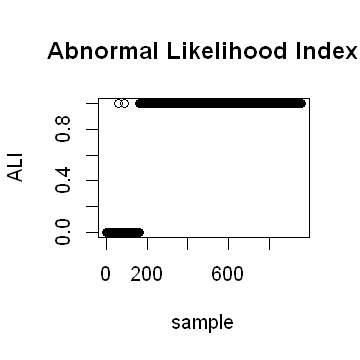

In [187]:
ALI(gaussian_total1, "1")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

      mu  s.d.
F1 0.267 0.006
             F1
F1 3.635176e-05
         mu  s.d.
F2 3655.728 18.79
         F2
F2 353.0804
         mu   s.d.
F3 4442.624 25.027
         F3
F3 626.3647
      mu  s.d.
F4 9.239 0.053
            F4
F4 0.002837851
       mu s.d.
F5 36.768  0.2
           F5
F5 0.04019794
       mu s.d.
F6 47.378 0.21
           F6
F6 0.04416408
         mu  s.d.
P7 2831.673 0.983
          P7
P7 0.9661492
       mu  s.d.
L8 69.354 0.506
         L8
L8 0.256503
        mu  s.d.
T9 122.917 0.011
             T9
T9 0.0001190006
       mu s.d.
F10 0.049 0.01
             F10
F10 0.0001068873
        mu s.d.
T11 87.102 0.06
            T11
T11 0.003573657
        mu  s.d.
L12 43.726 1.025
         L12
L12 1.049669
          mu  s.d.
P13 2612.271 0.434
          P13
P13 0.1882575
        mu  s.d.
F14 26.144 0.131
           F14
F14 0.01714722
        mu  s.d.
L15 51.201 1.056
        L15
L15 1.11529
          mu  s.d.
P16 3257.622 0.486
          P16
P16 0.2361463
        mu  s.

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


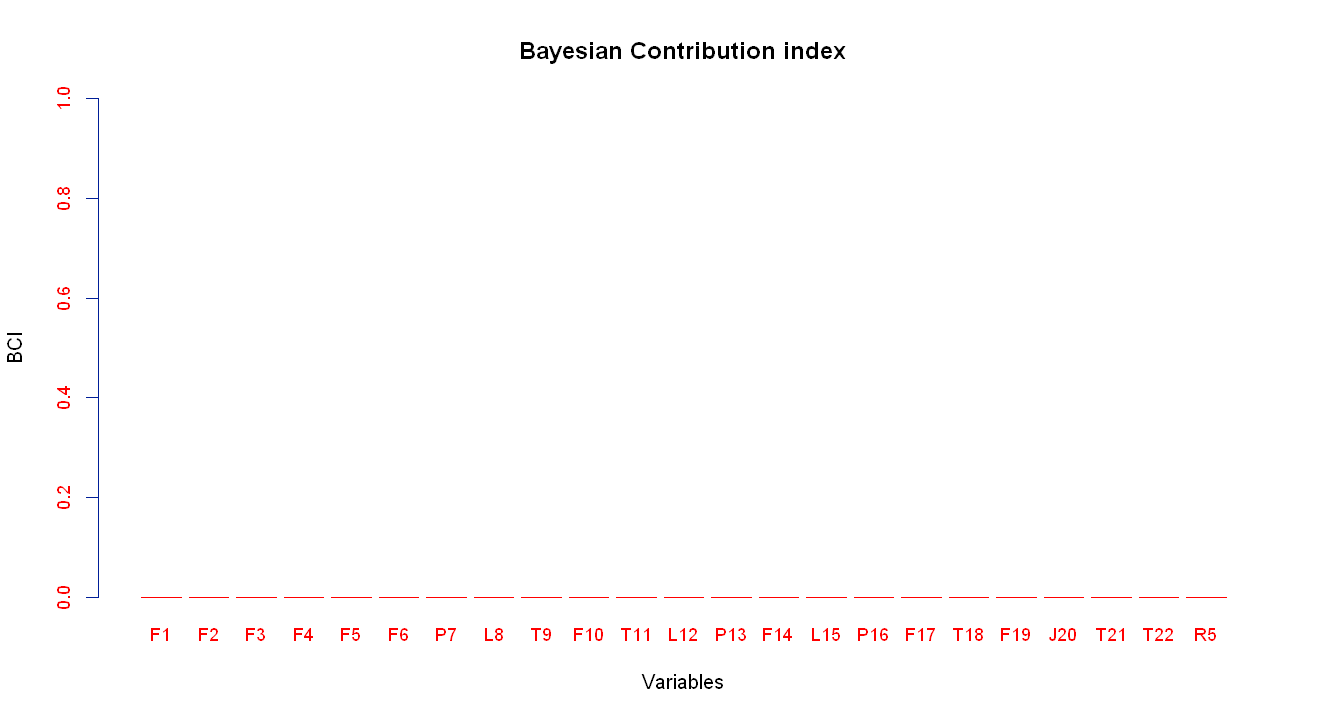

In [227]:
bci_1a = BCI(gaussian_total1, "default1", 161, 160)
bci_1a

BCI_plot(bci_1a)

<hr>

<span style="color:green"><font size="5"><b>[IDV1] Obtained</b></font></span> 

Fault Occured at 162


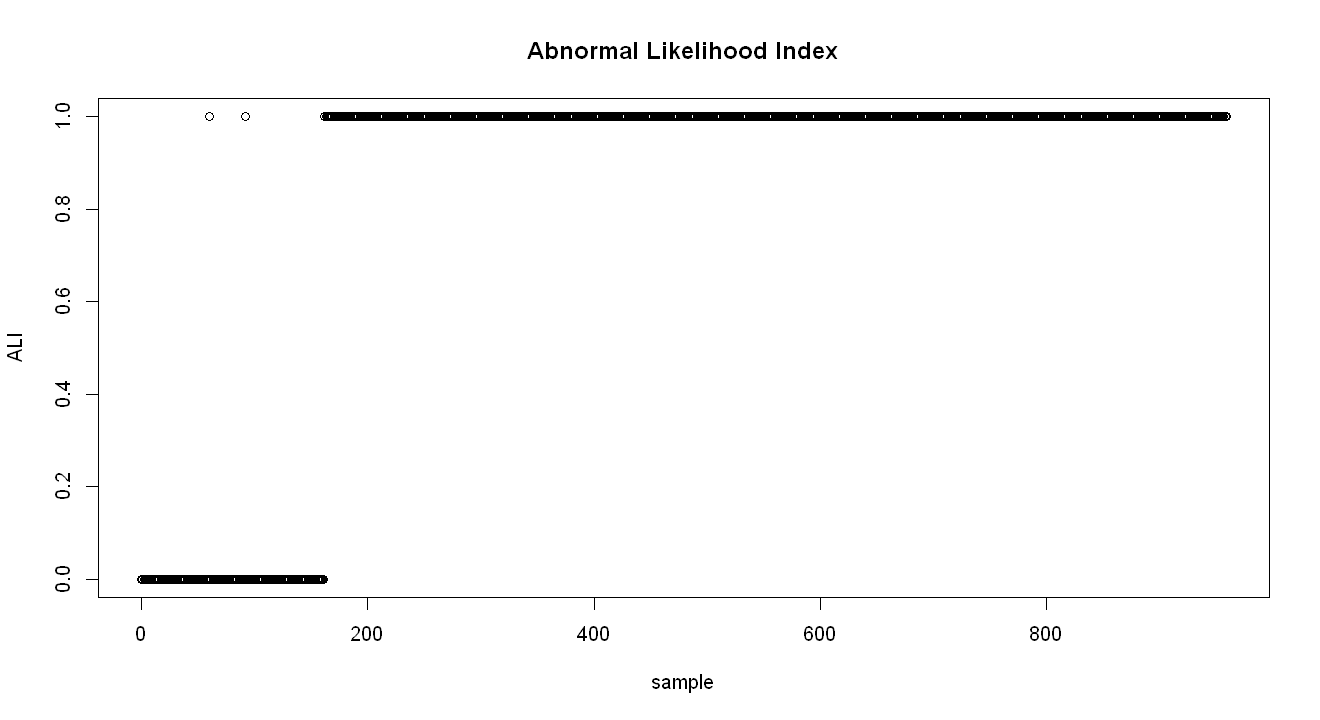

In [189]:
ALI(gaussian_total2, "1")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.9551151,0.7131297,0.9345244,0.8628193,1.003125,1.003125,1.002822,1.003125,1.003125,1.003125,...,0.9430289,0.8307169,1.003125,0.8925847,1.003125,1.003125,1.003125,1.003125,1.003125,1.003125


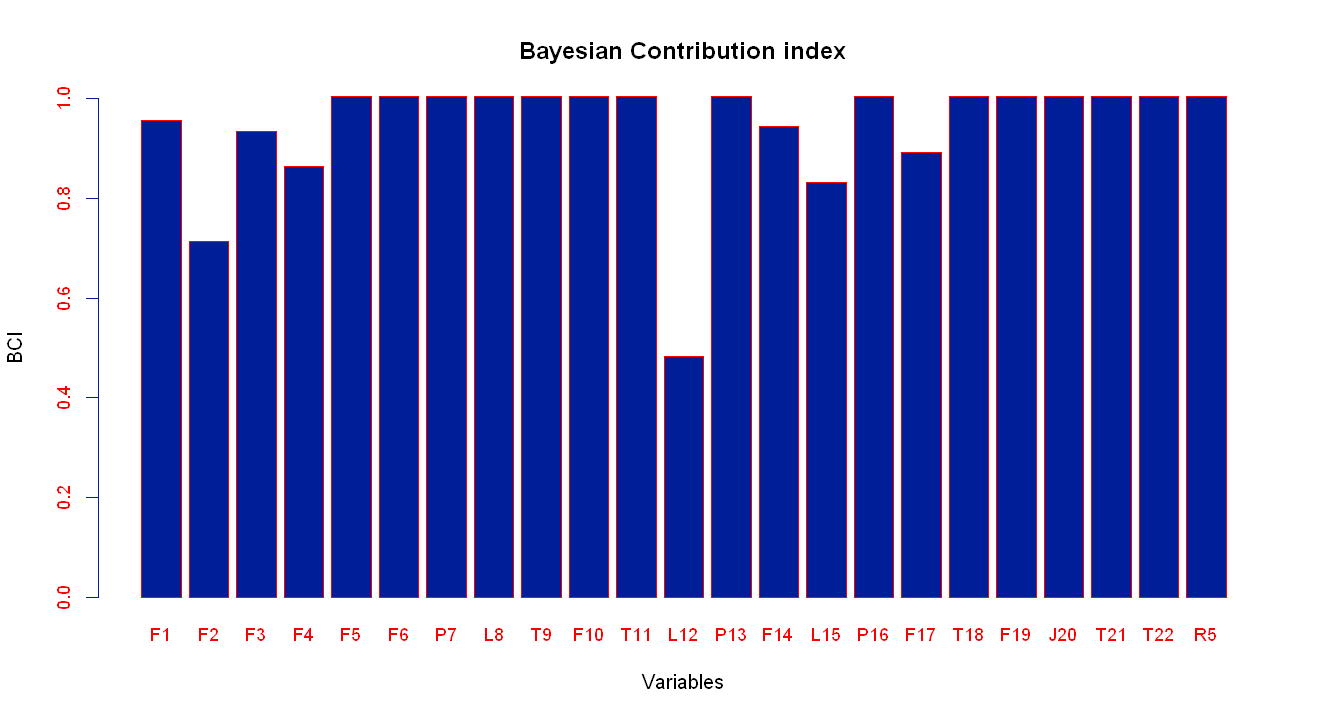

In [229]:
bci_1 = BCI(gaussian_total2, "default1", 161, 160)
bci_1

BCI_plot(bci_1)

<hr>

<span style="color:purple"><font size="5"><b>[IDV2] Given</b></font></span> 

Fault Occured at 161


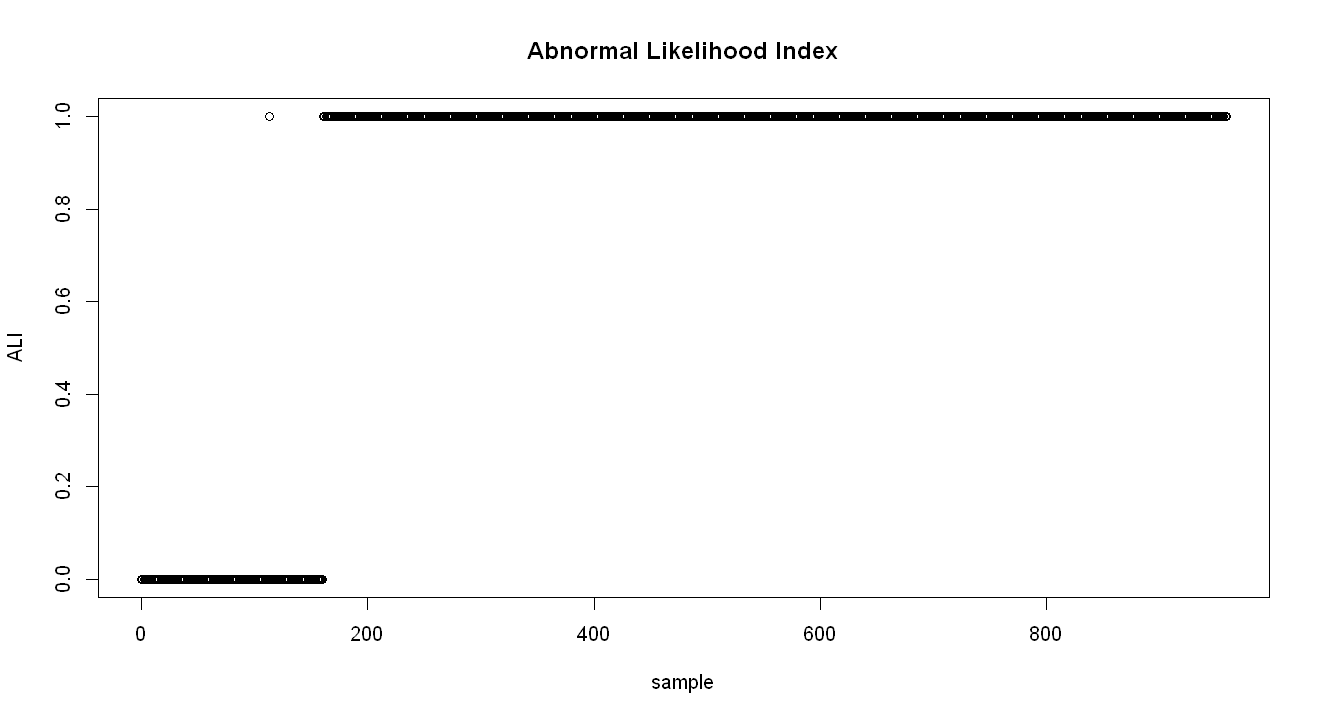

In [169]:
ALI(gaussian_total1, "2")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.5979924,0.5484541,0.7338195,0.7087914,0.5239298,0.5816139,0.5050544,0.5301012,0.5118497,0.7264861,...,0.5436004,0.4942924,0.1765009,0.5251283,0.7610984,0.7160505,0.5130444,0.6514402,0.6968609,0.5213831


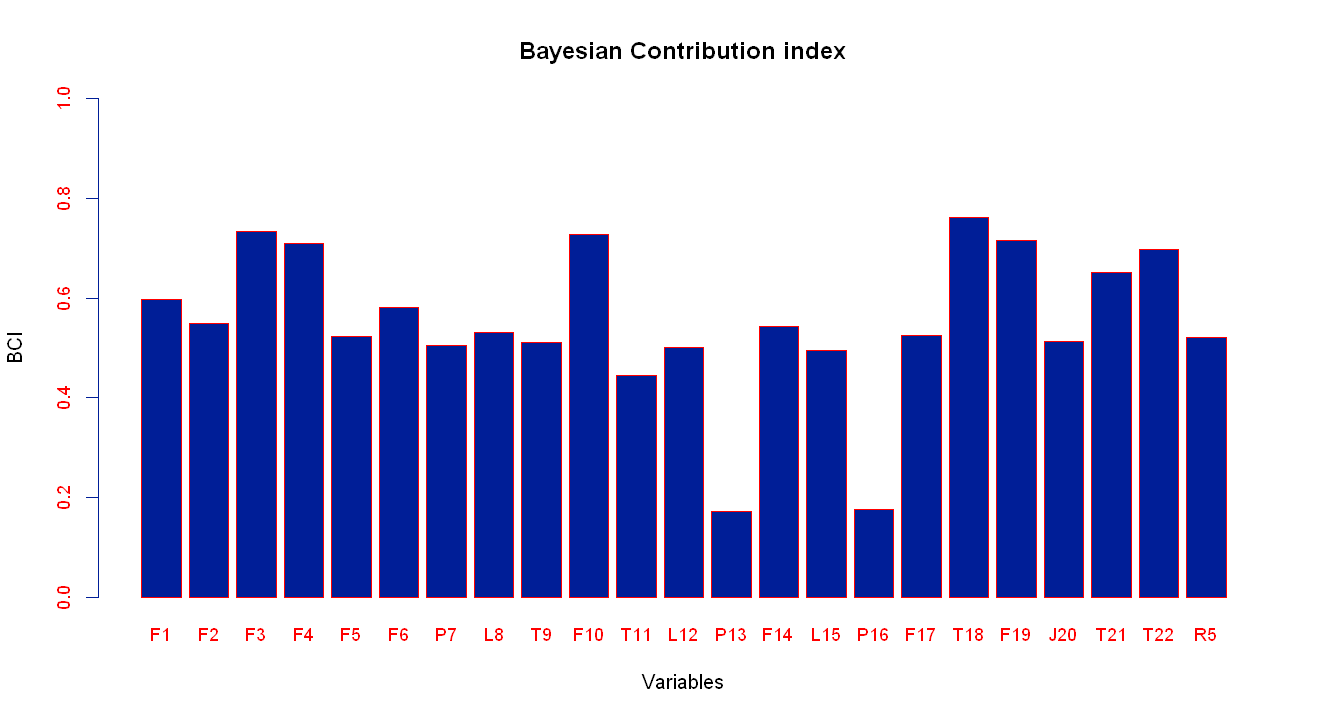

In [170]:
bci_2a = BCI(gaussian_total1, "default2", 161, 160)
bci_2a

BCI_plot(bci_2a)

<hr>

<span style="color:green"><font size="5"><b>[IDV2] Obtained</b></font></span> 

Fault Occured at 161


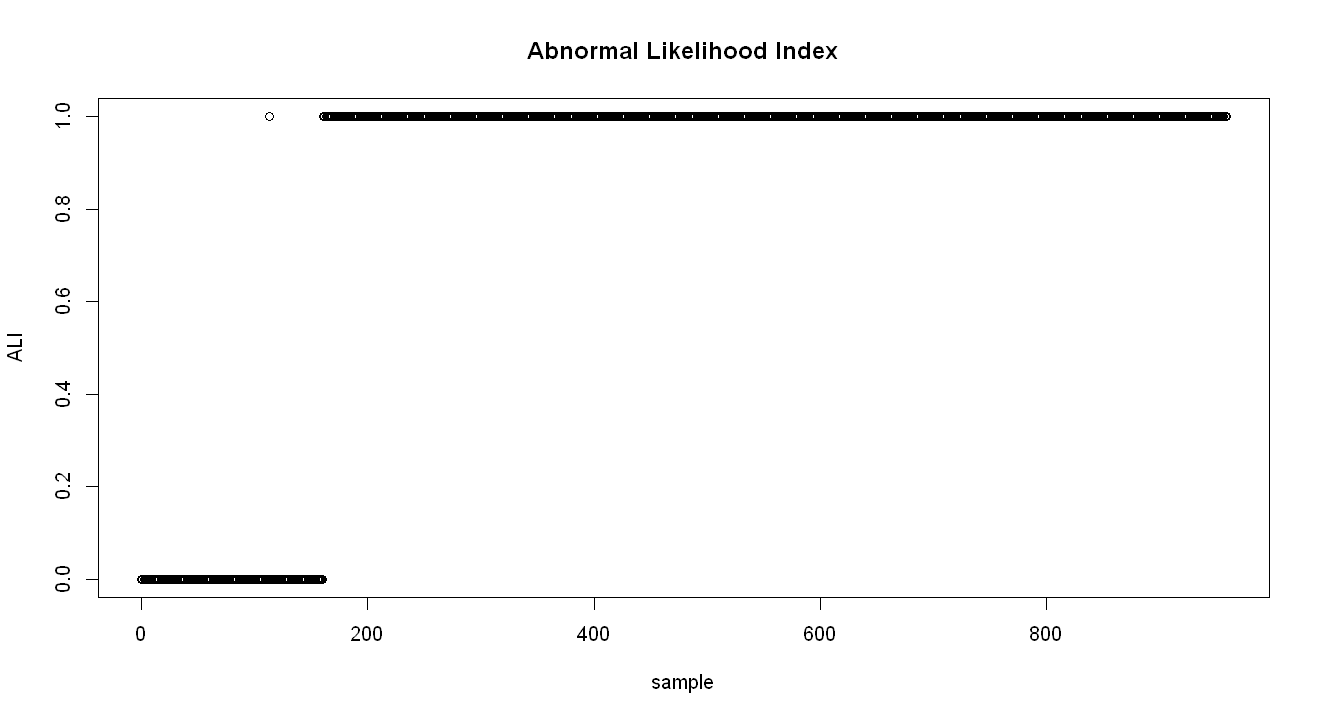

In [171]:
ALI(gaussian_total2, "2")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.5977001,0.548454,0.7338017,0.7087914,0.5275522,0.5816139,0.4806947,0.5335015,0.5136822,0.7264861,...,0.5437567,0.4954186,0.1842437,0.5229143,0.8576306,0.7219253,0.5073128,0.6286364,0.7645311,0.5213561


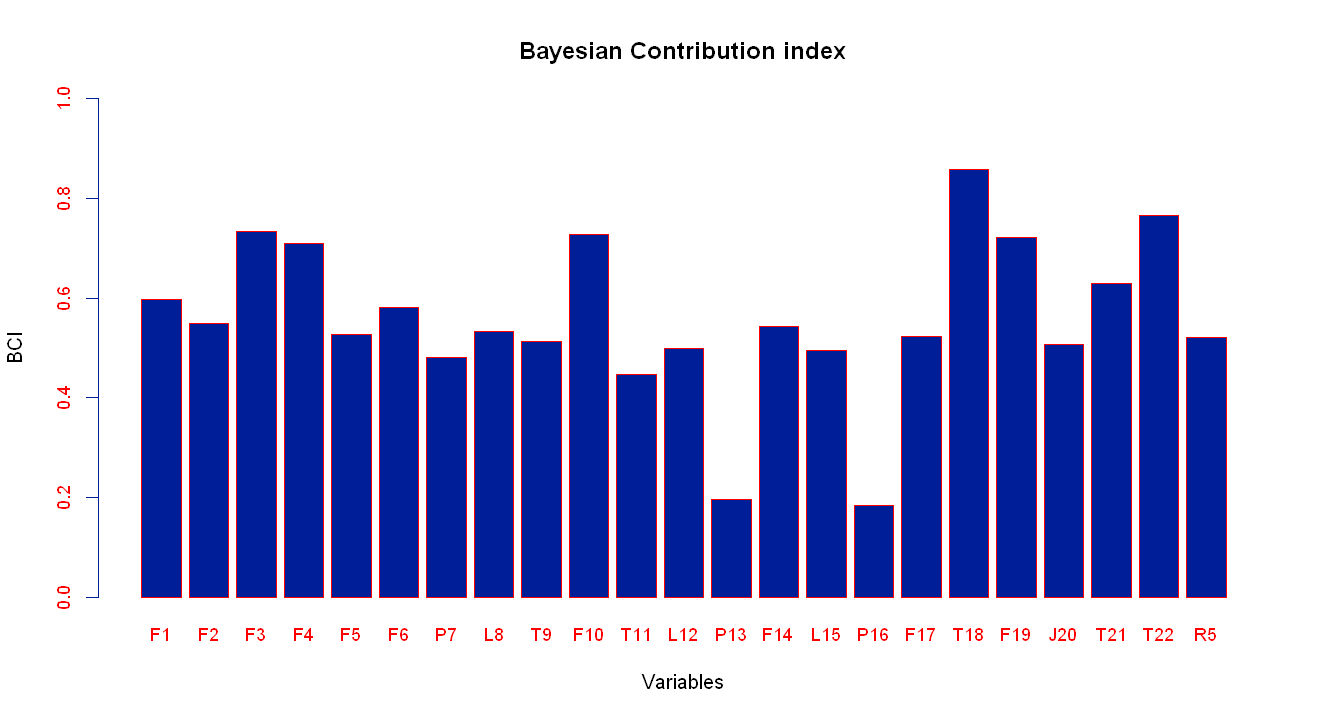

In [172]:
bci_2 = BCI(gaussian_total2, "default2", 161, 160)
bci_2

BCI_plot(bci_2)

<hr>

<span style="color:purple"><font size="5"><b>[IDV3] Given</b></font></span> 

Fault Occured at 161


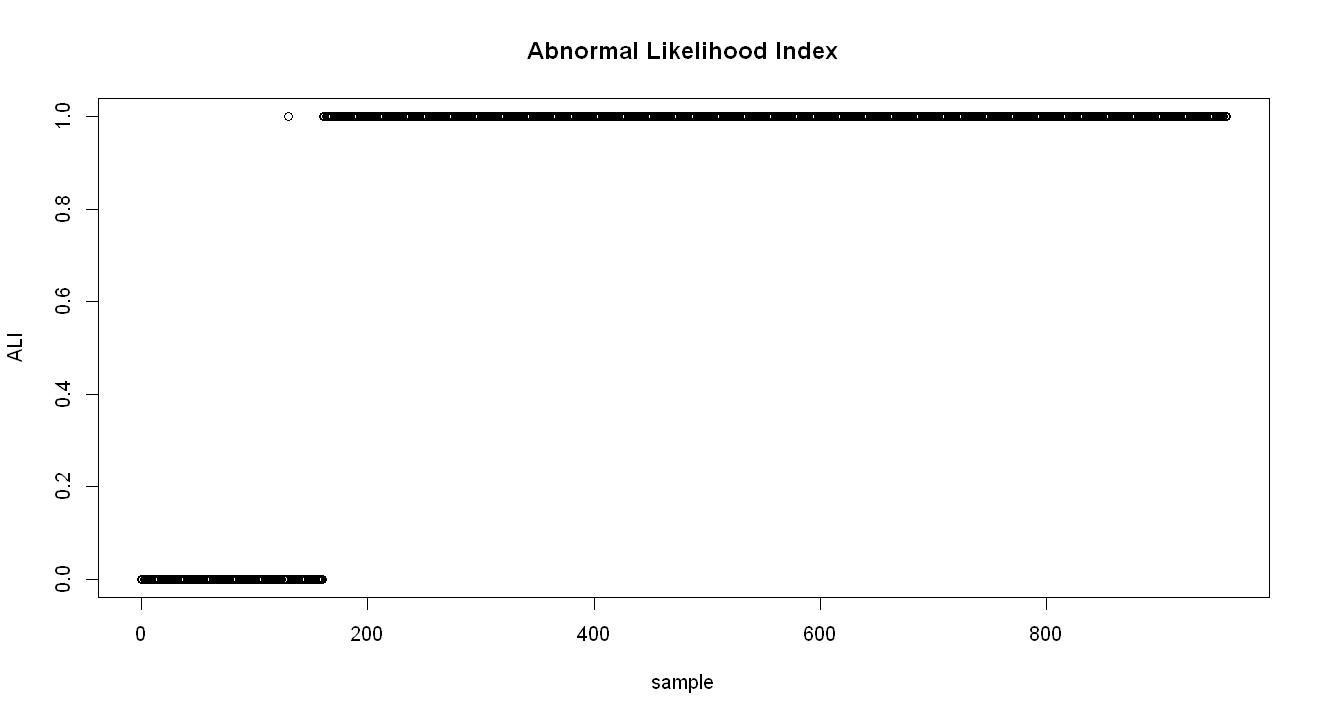

In [173]:
ALI(gaussian_total1, "3")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


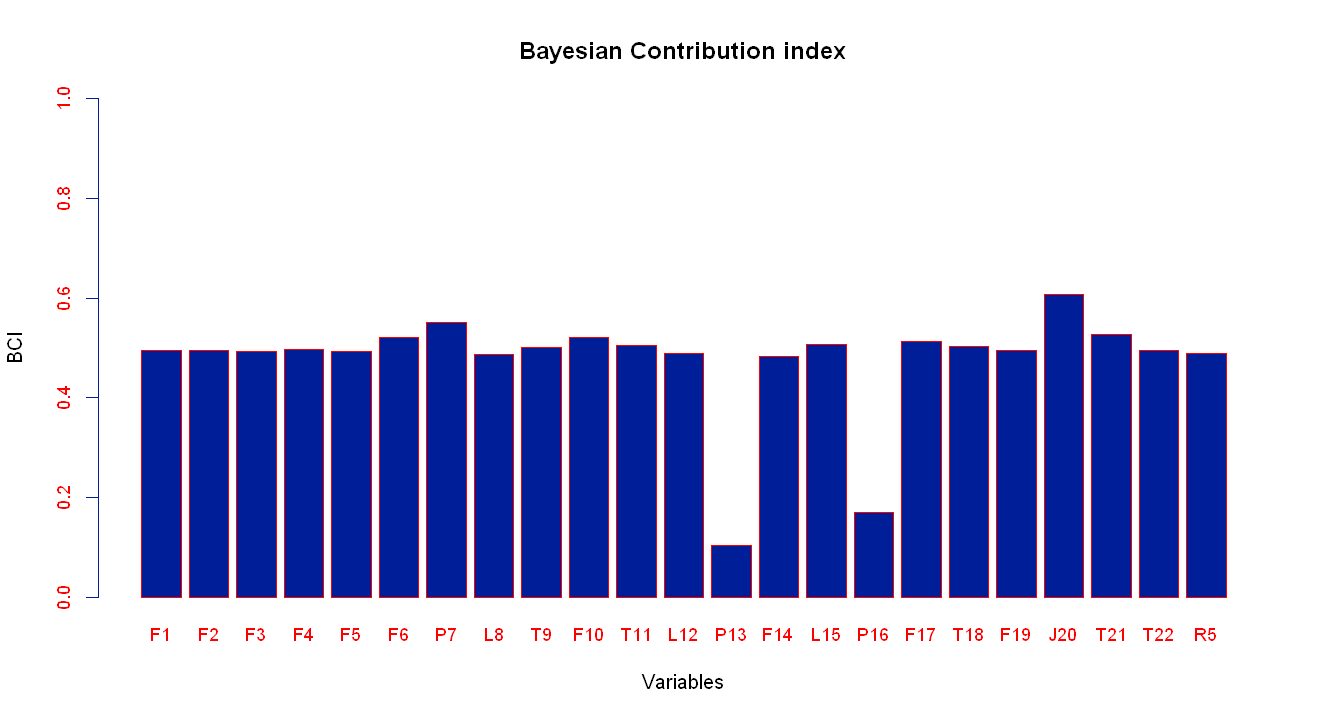

In [174]:
bci_3a = BCI(gaussian_total1, "default3", 161, 160)
bci_3a

BCI_plot(bci_3a)

<hr>

<span style="color:green"><font size="5"><b>[IDV3] Obtained</b></font></span> 

Fault Occured at 161


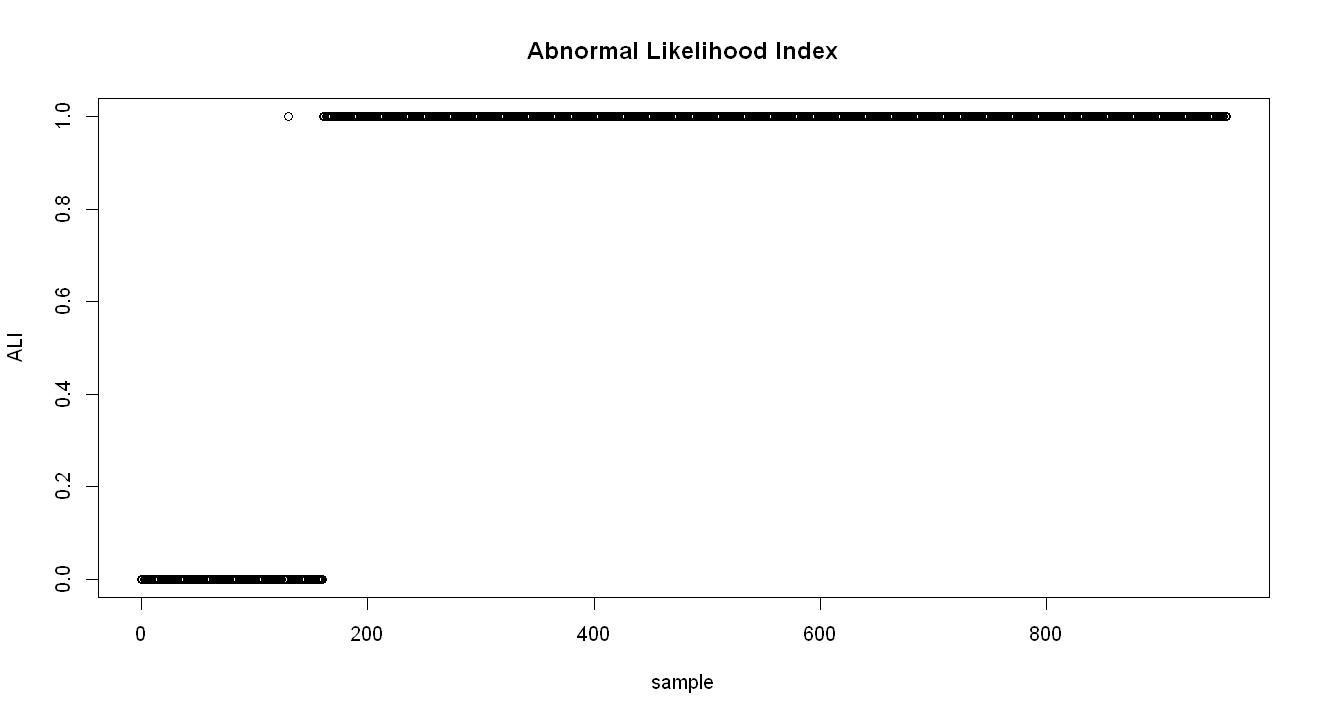

In [175]:
ALI(gaussian_total2, "3")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


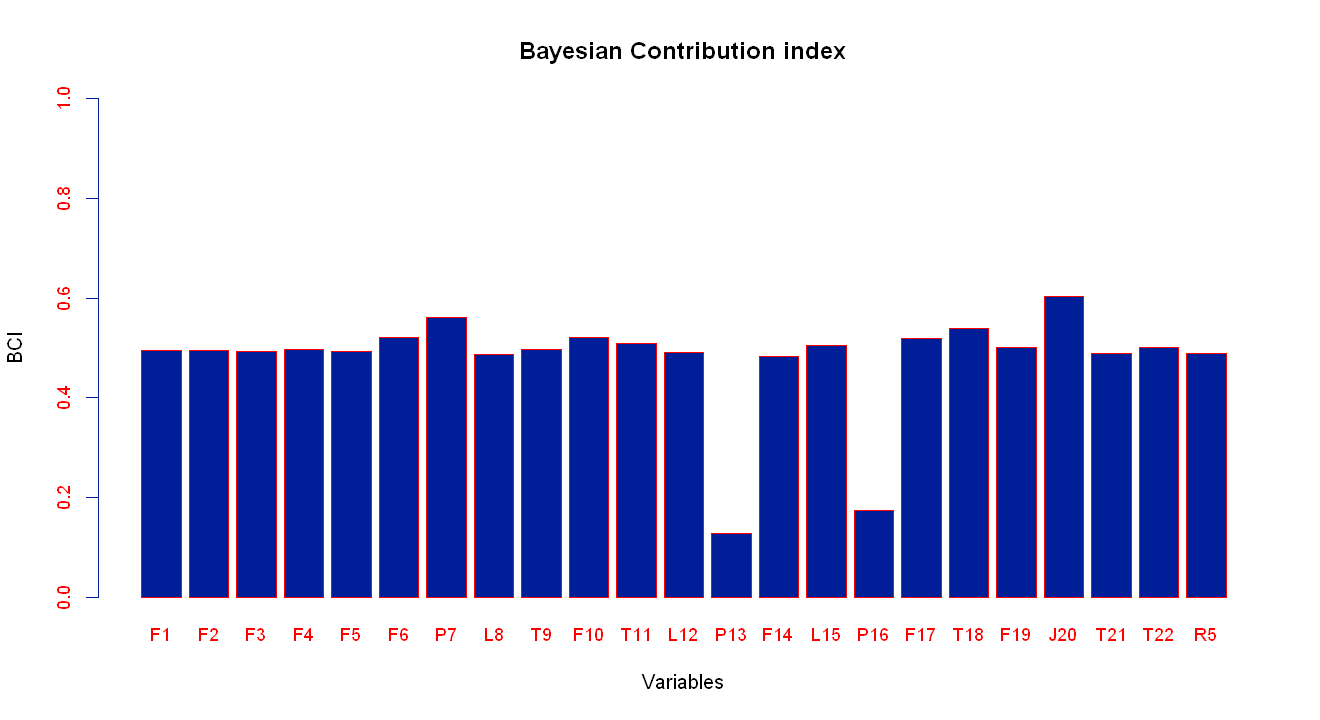

In [176]:
bci_3 = BCI(gaussian_total2, "default3", 161, 160)
bci_3

BCI_plot(bci_3)

<hr>

<span style="color:purple"><font size="5"><b>[IDV4] Given</b></font></span> 

Fault Occured at 161


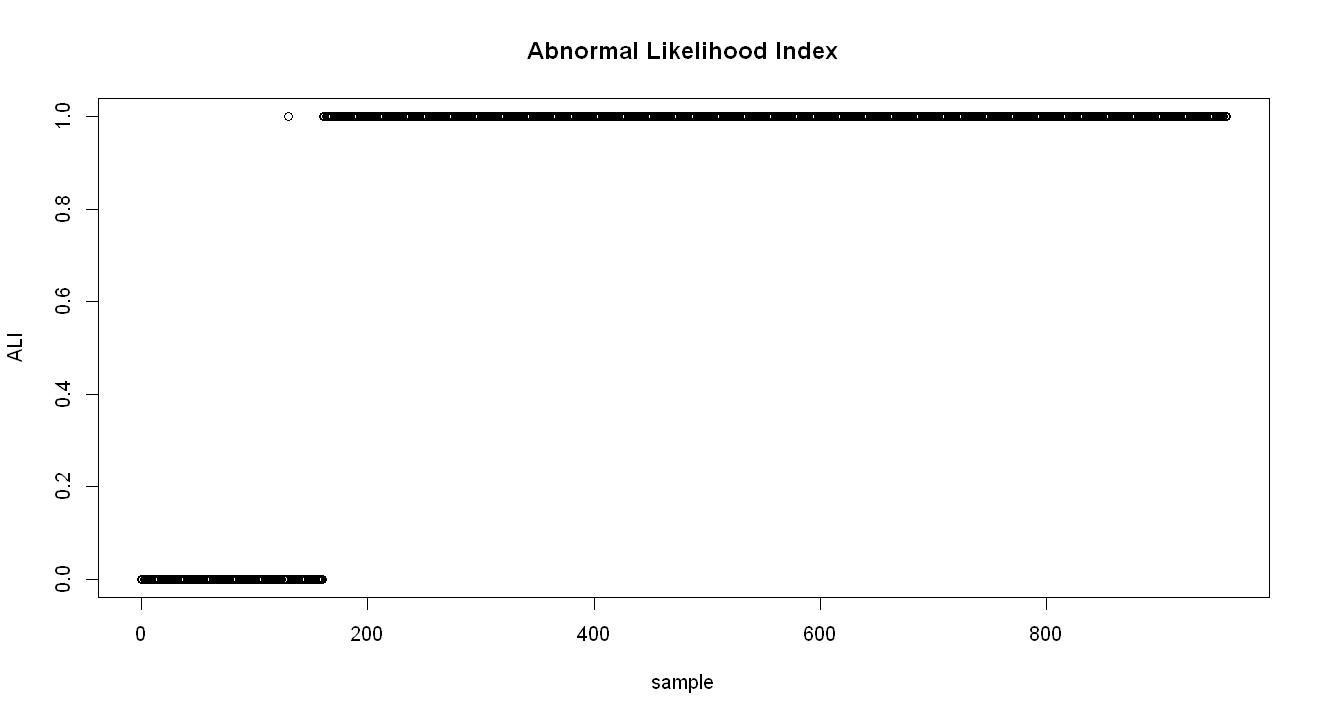

In [173]:
ALI(gaussian_total1, "4")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


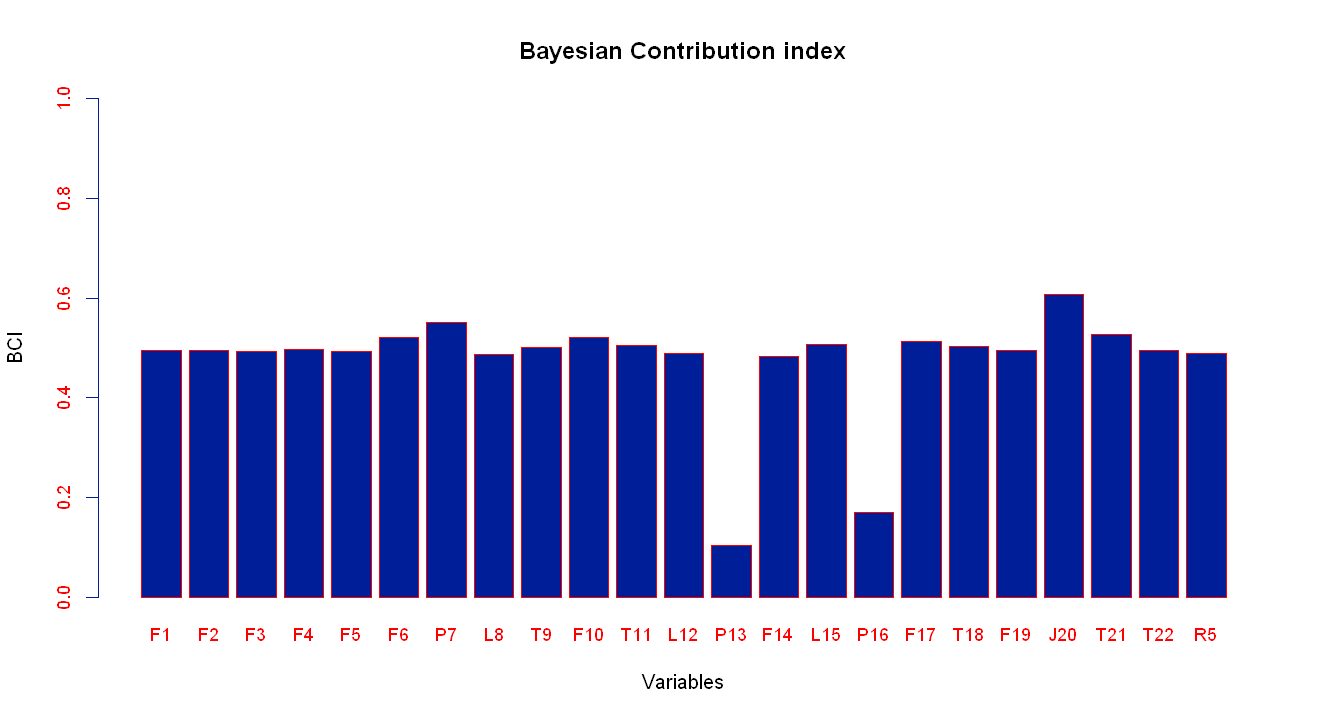

In [174]:
bci_4a = BCI(gaussian_total1, "default4", 161, 160)
bci_4a

BCI_plot(bci_4a)

<hr>

<span style="color:green"><font size="5"><b>[IDV4] Obtained</b></font></span> 

Fault Occured at 161


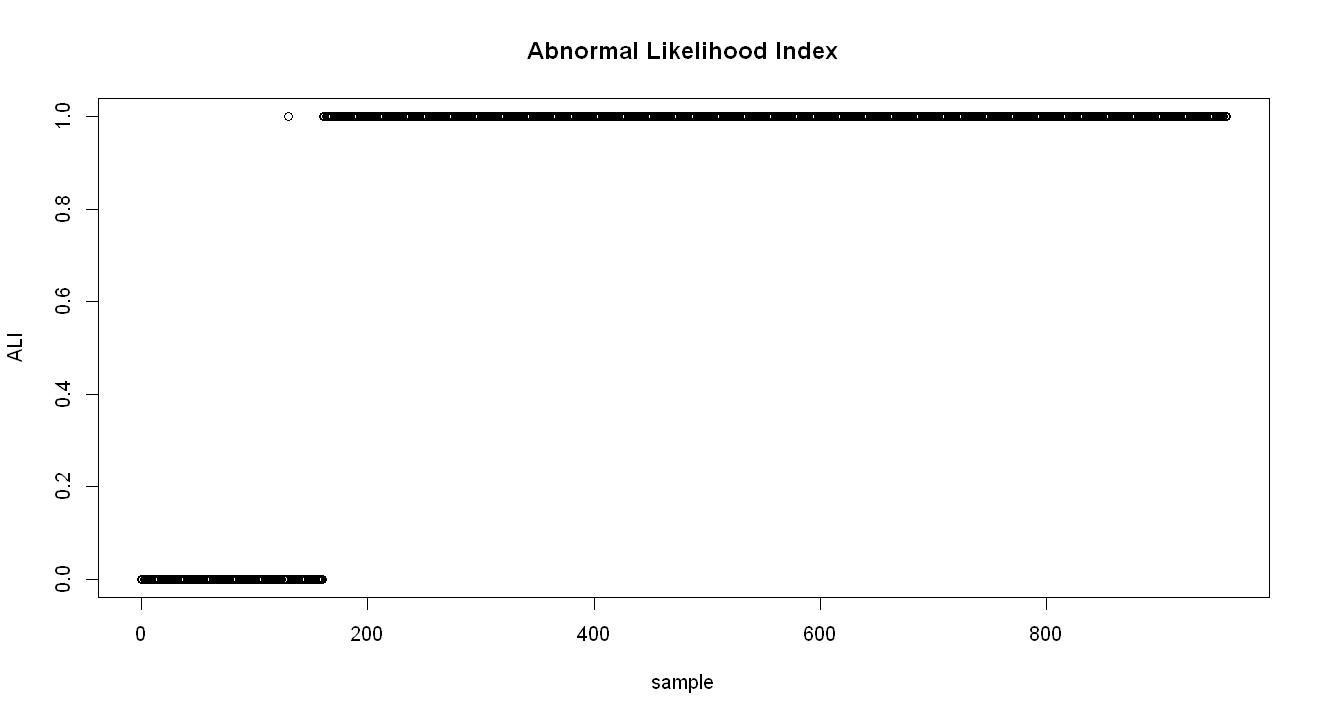

In [175]:
ALI(gaussian_total2, "4")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


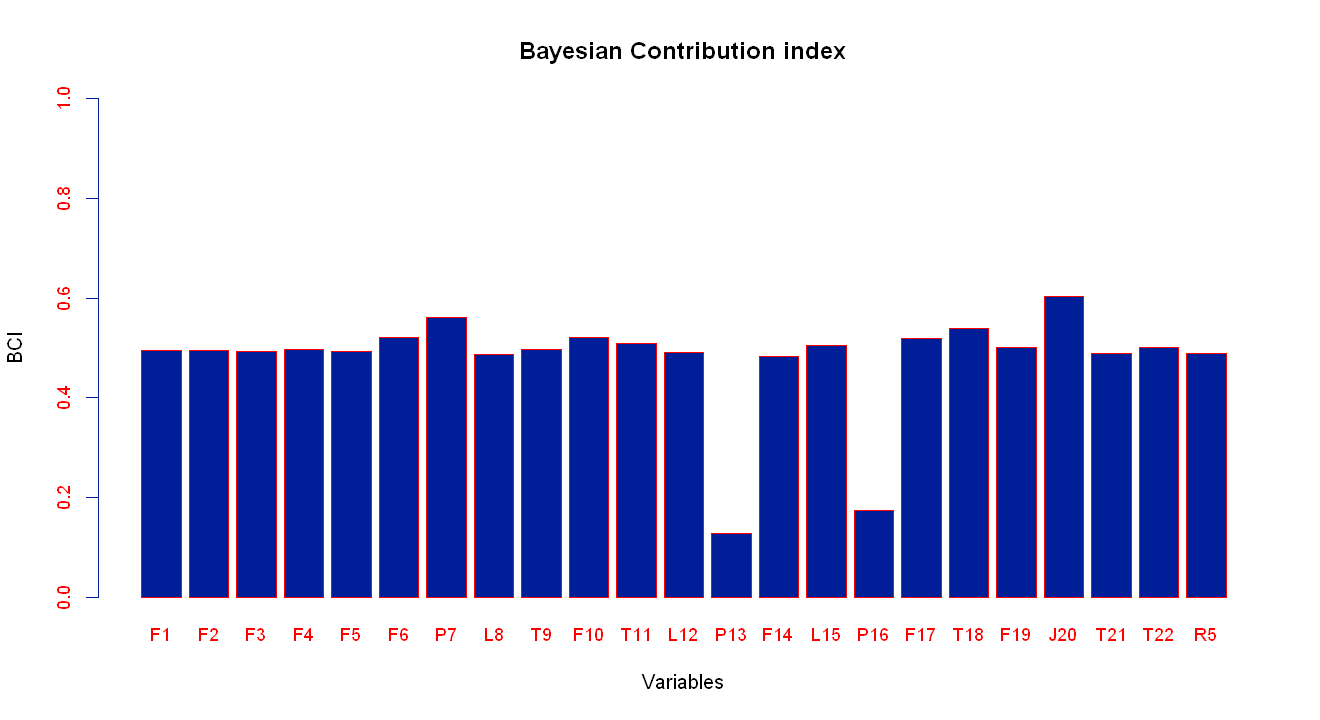

In [176]:
bci_4 = BCI(gaussian_total2, "default4", 161, 160)
bci_4

BCI_plot(bci_4)

<hr>

<span style="color:purple"><font size="5"><b>[IDV5] Given</b></font></span> 

Fault Occured at 161


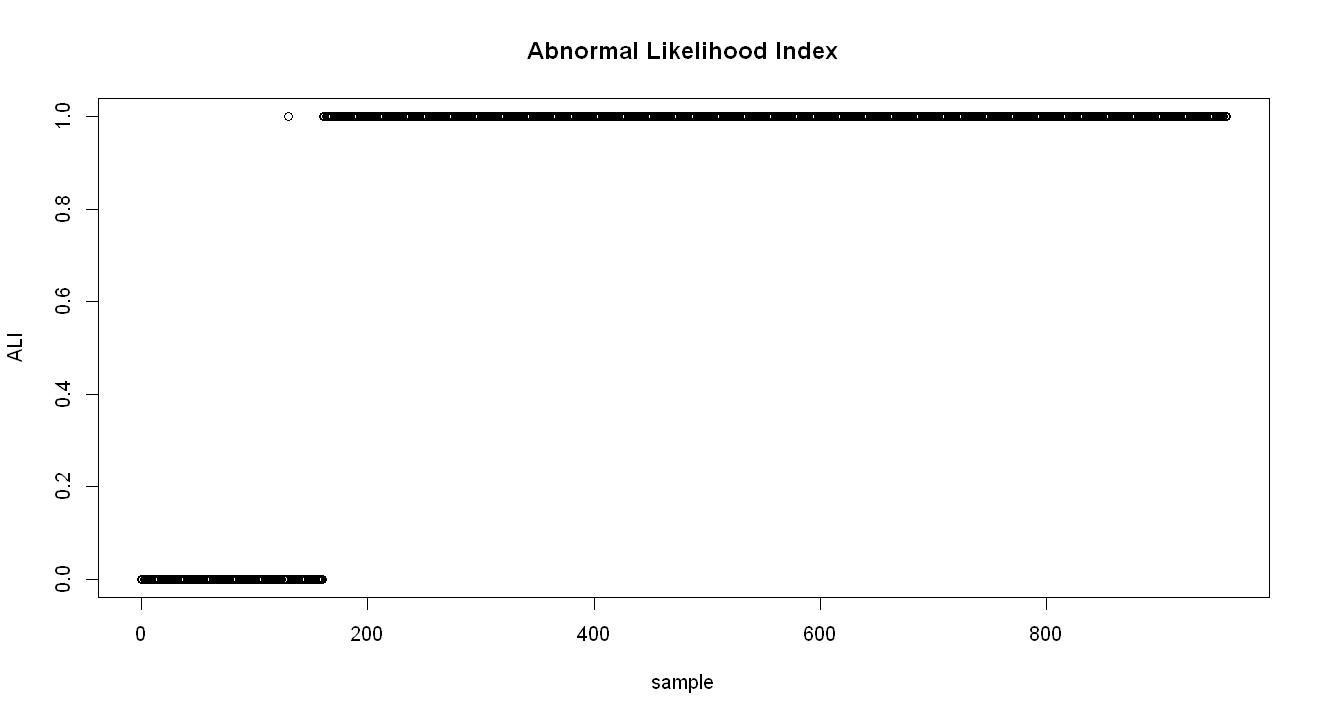

In [173]:
ALI(gaussian_total1, "5")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


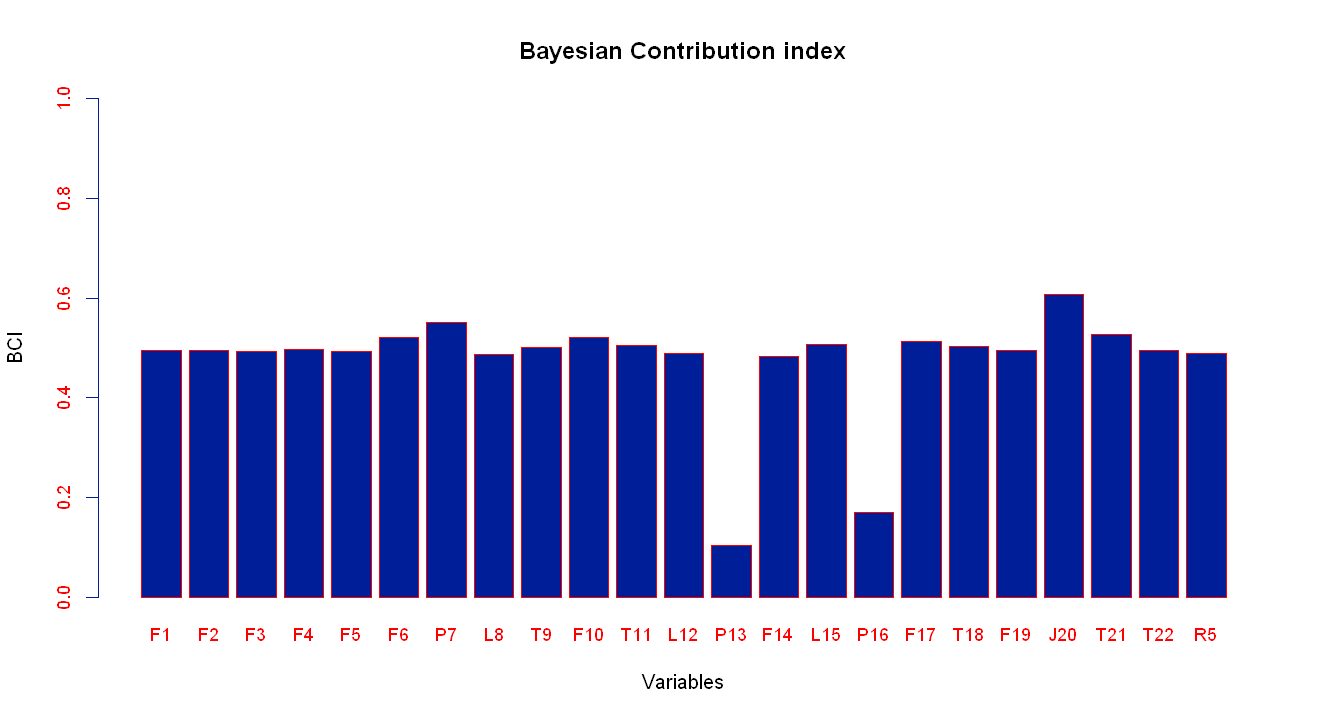

In [174]:
bci_5a = BCI(gaussian_total1, "default5", 161, 160)
bci_5a

BCI_plot(bci_5a)

<hr>

<span style="color:green"><font size="5"><b>[IDV5] Obtained</b></font></span> 

Fault Occured at 161


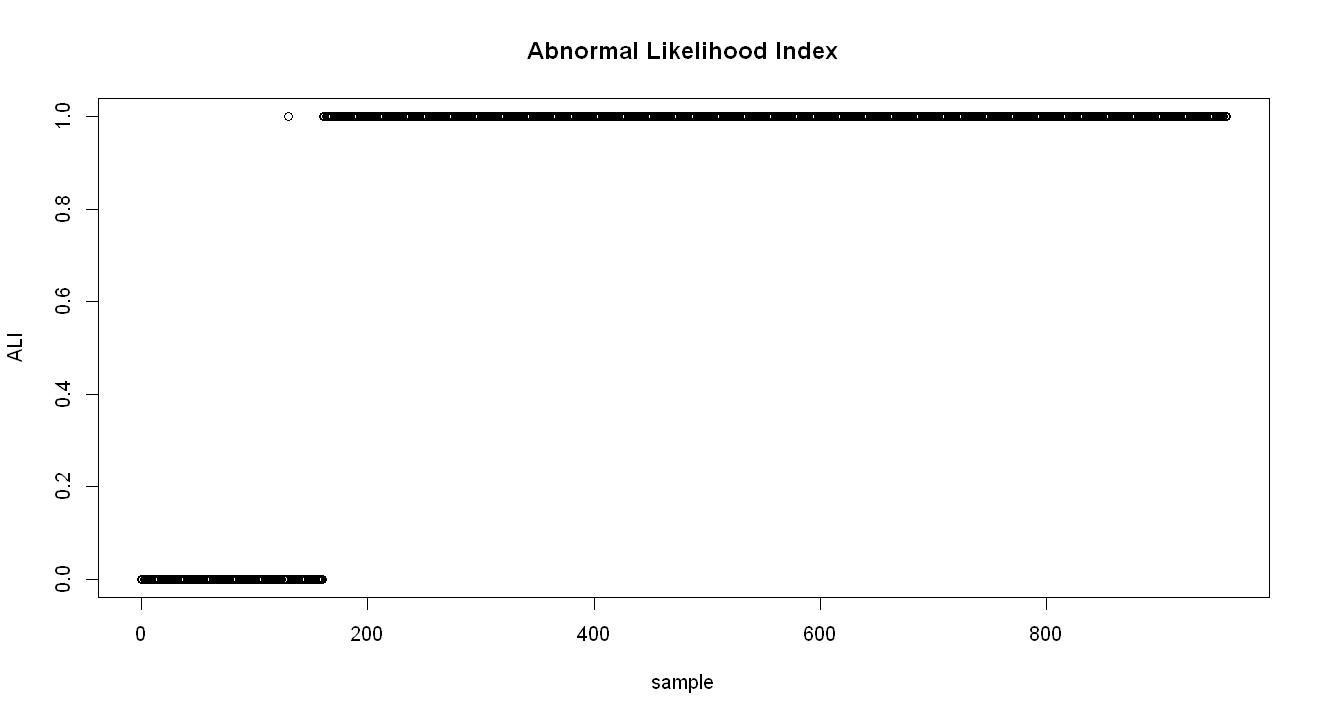

In [175]:
ALI(gaussian_total2, "5")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


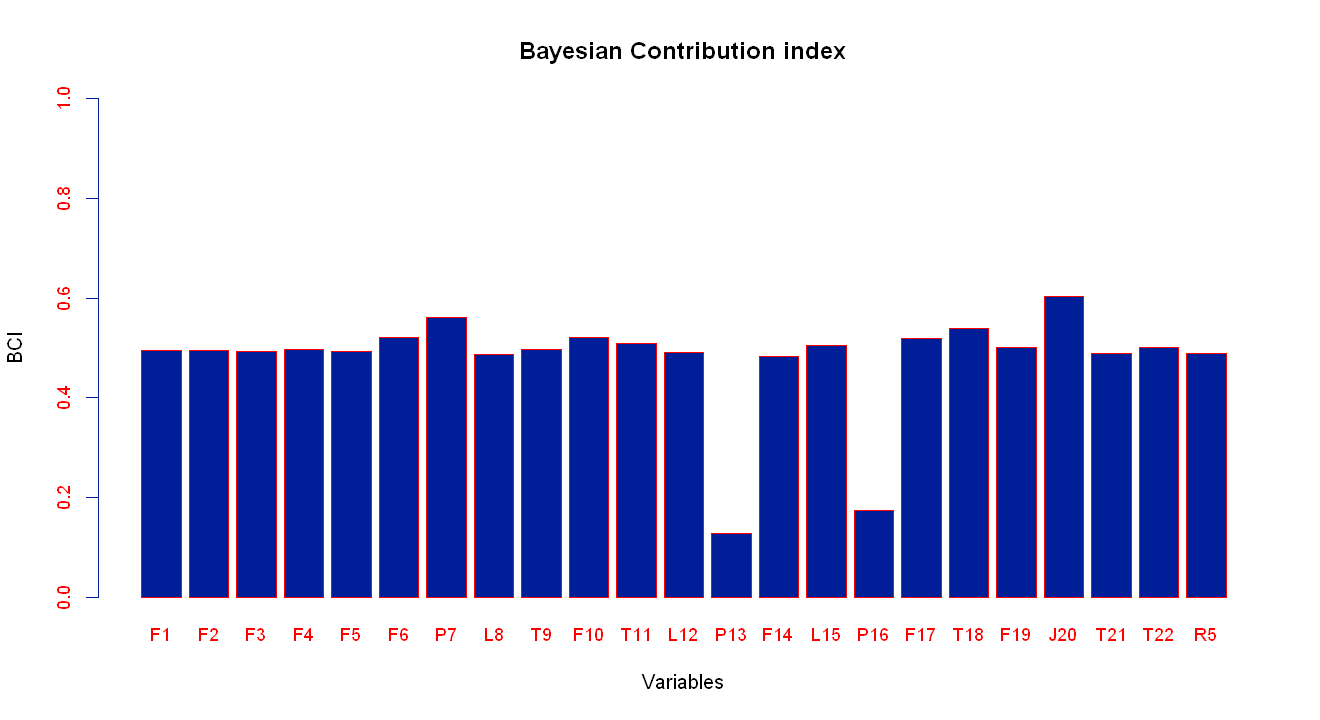

In [176]:
bci_5 = BCI(gaussian_total2, "default5", 161, 160)
bci_5

BCI_plot(bci_5)

<hr>

<span style="color:purple"><font size="5"><b>[IDV6] Given</b></font></span> 

Fault Occured at 164


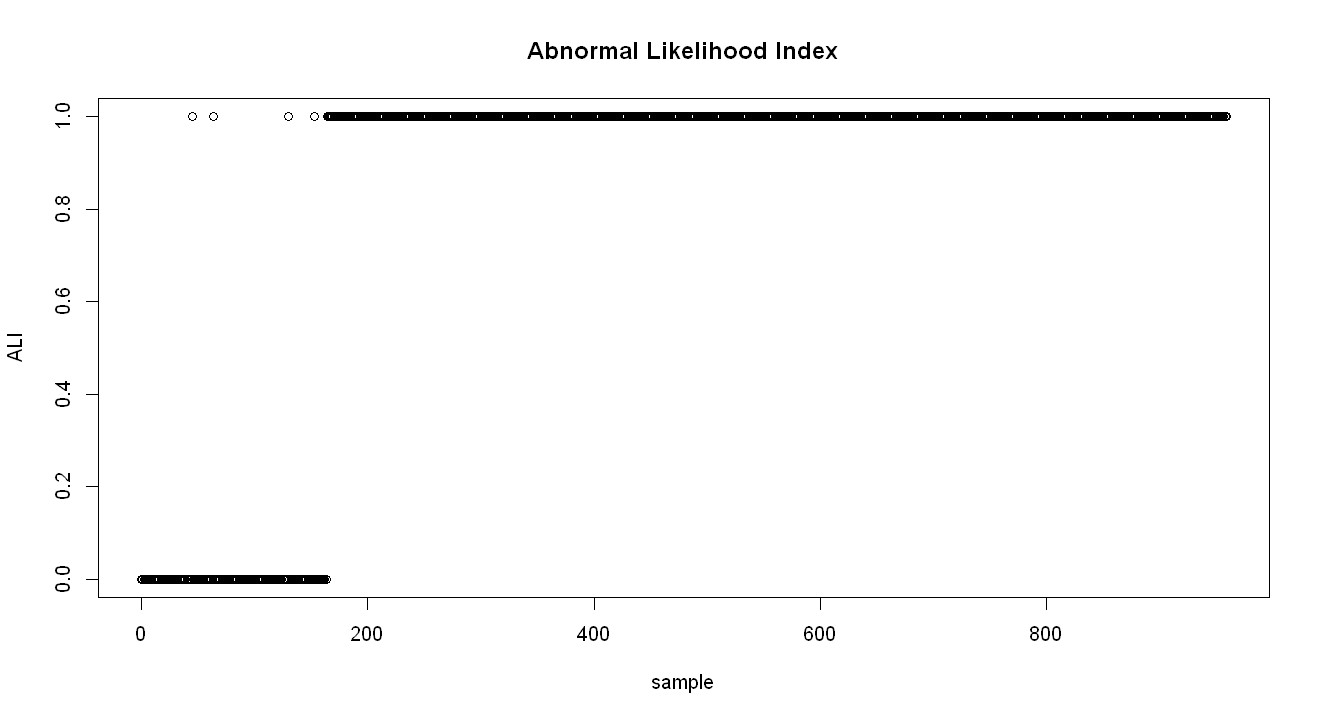

In [191]:
ALI(gaussian_total1, "6")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.9352415,0.7459943,0.883241,0.8911428,1.003125,1.003125,1.002515,1.003125,1.003125,0.965057,...,0.9532842,0.8539226,1.003125,0.9578688,1.000568,1.003125,1.003125,1.003125,1.003125,1.003125


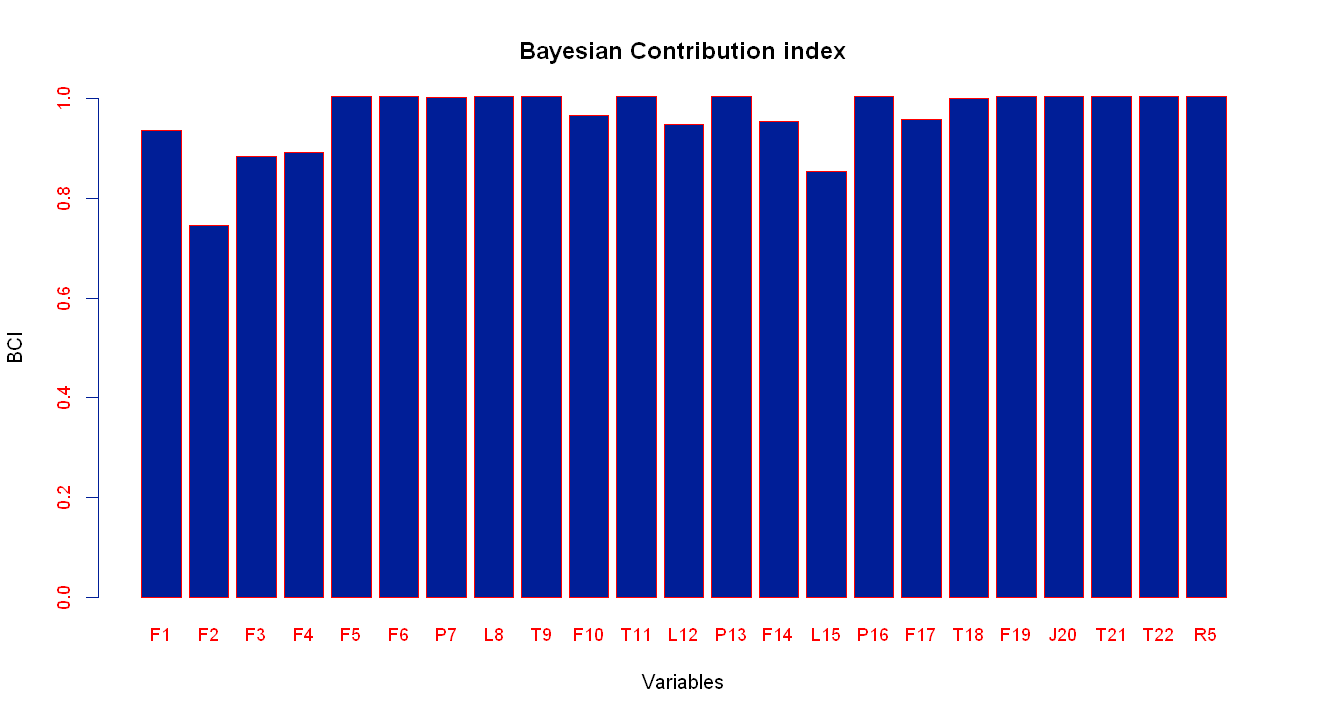

In [230]:
bci_6a = BCI(gaussian_total1, "default6", 161, 160)
bci_6a

BCI_plot(bci_6a)

<hr>

<span style="color:green"><font size="5"><b>[IDV6] Obtained</b></font></span> 

Fault Occured at 164


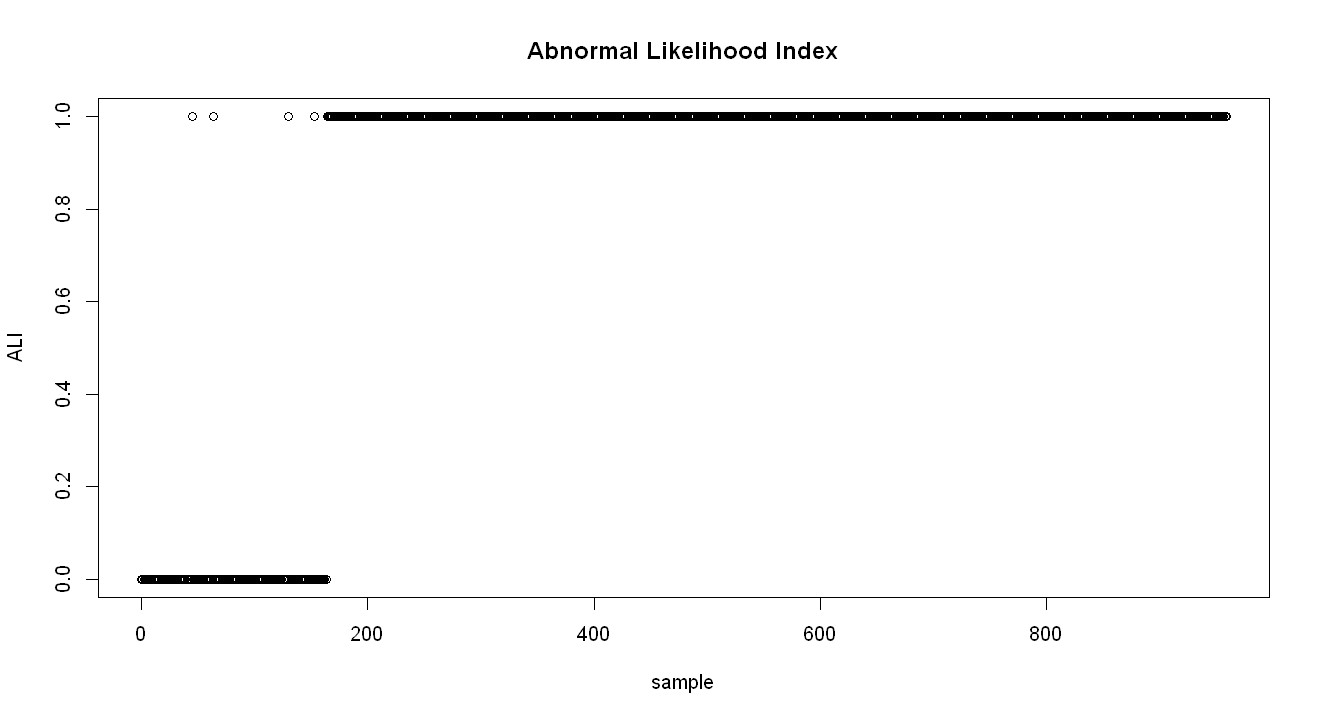

In [193]:
ALI(gaussian_total2, "6")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.1144812,0.9896574,0.993039,0.1720046,1.003125,1.003124,1.00307,1.003125,0.9988059,0.1619668,...,0.5194021,0.8902093,1.003125,0.3923622,1.002883,1.003125,1.003125,1.003125,1.003125,1.003125


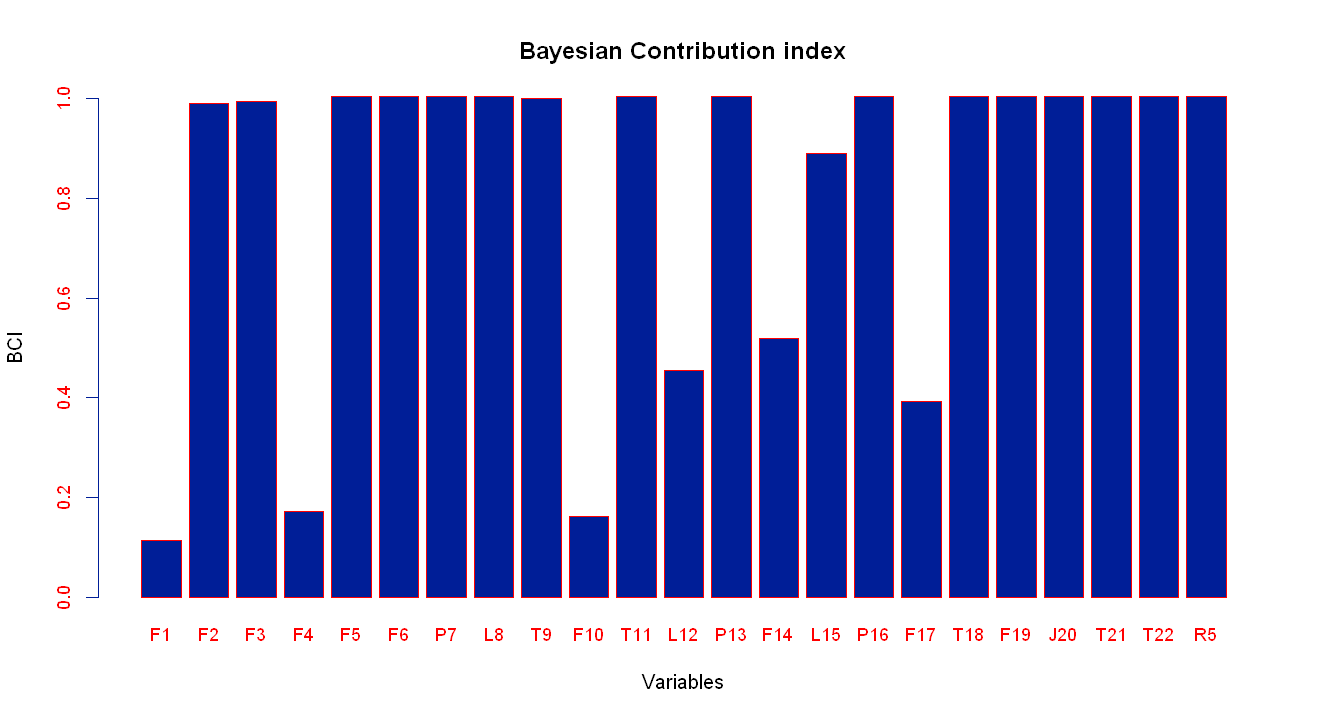

In [194]:
bci_6 = BCI(gaussian_total2, "default6", 161, 160)
bci_6

BCI_plot(bci_6)

<hr>

<span style="color:purple"><font size="5"><b>[IDV7] Given</b></font></span> 

Fault Occured at 161


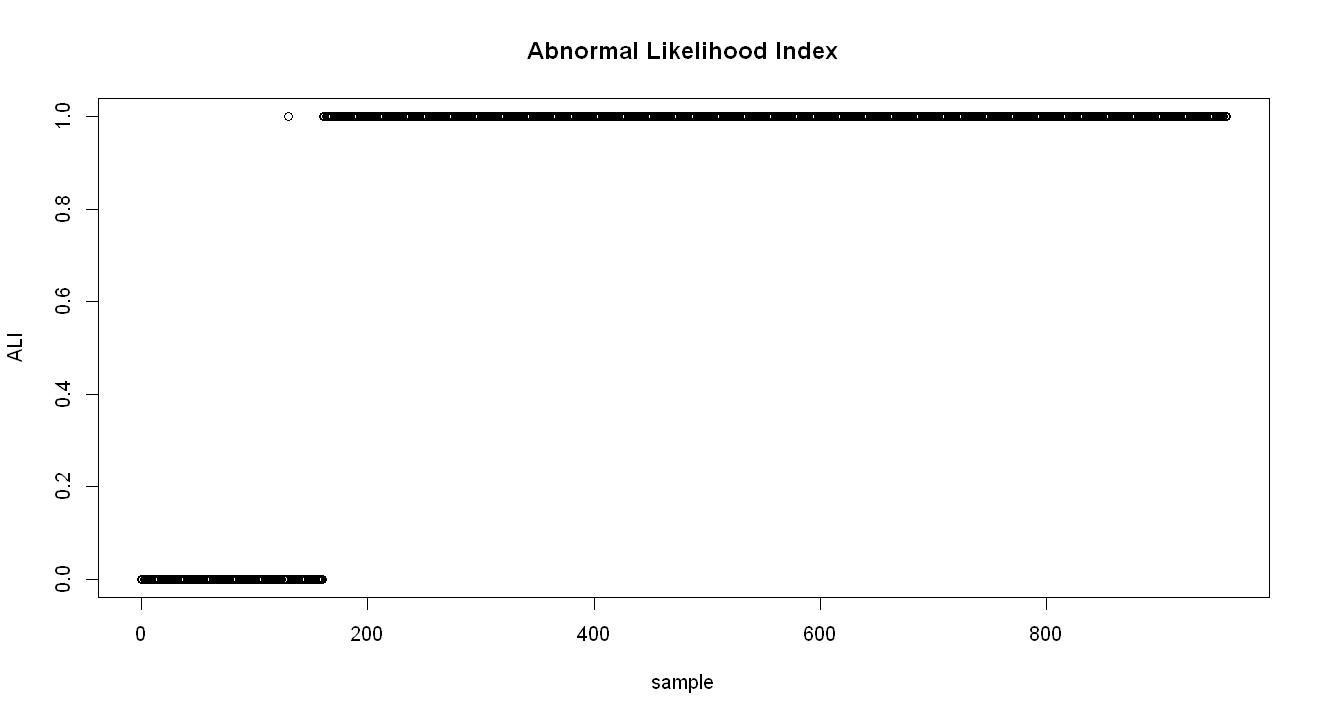

In [173]:
ALI(gaussian_total1, "7")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


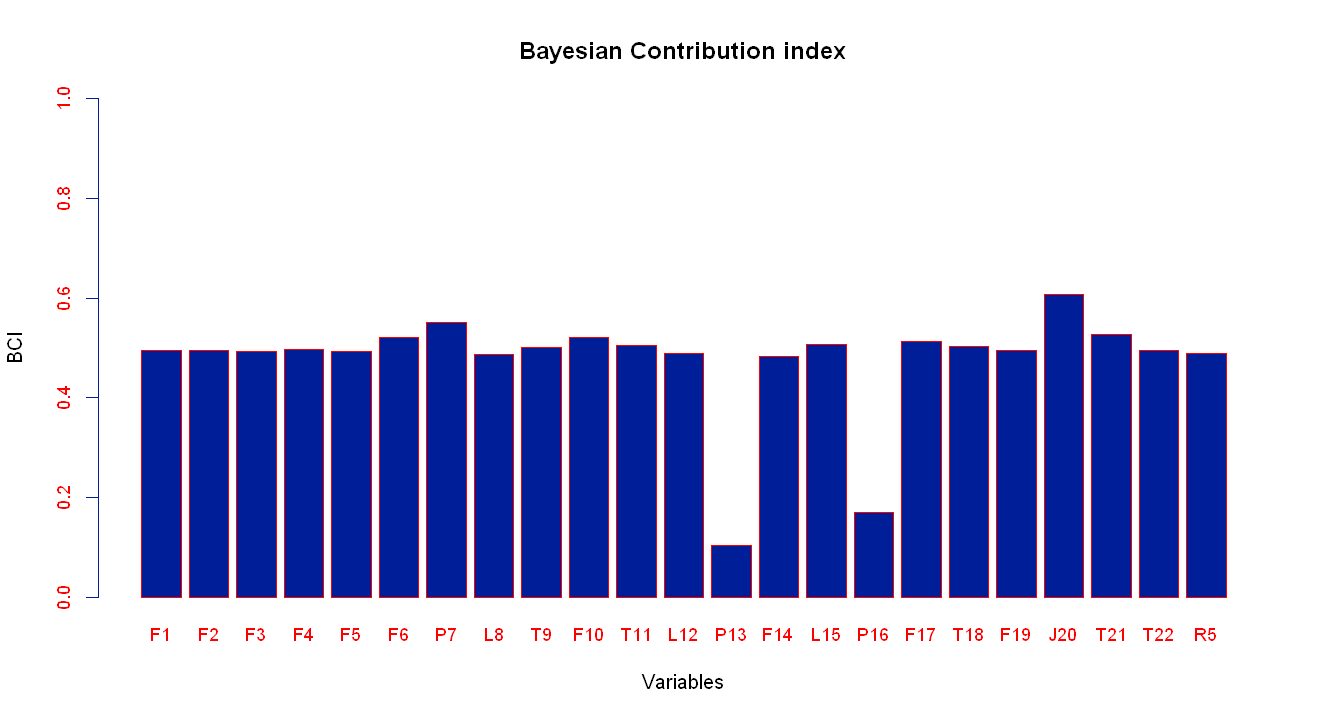

In [174]:
bci_7a = BCI(gaussian_total1, "default7", 161, 160)
bci_7a

BCI_plot(bci_7a)

<hr>

<span style="color:green"><font size="5"><b>[IDV7] Obtained</b></font></span> 

Fault Occured at 161


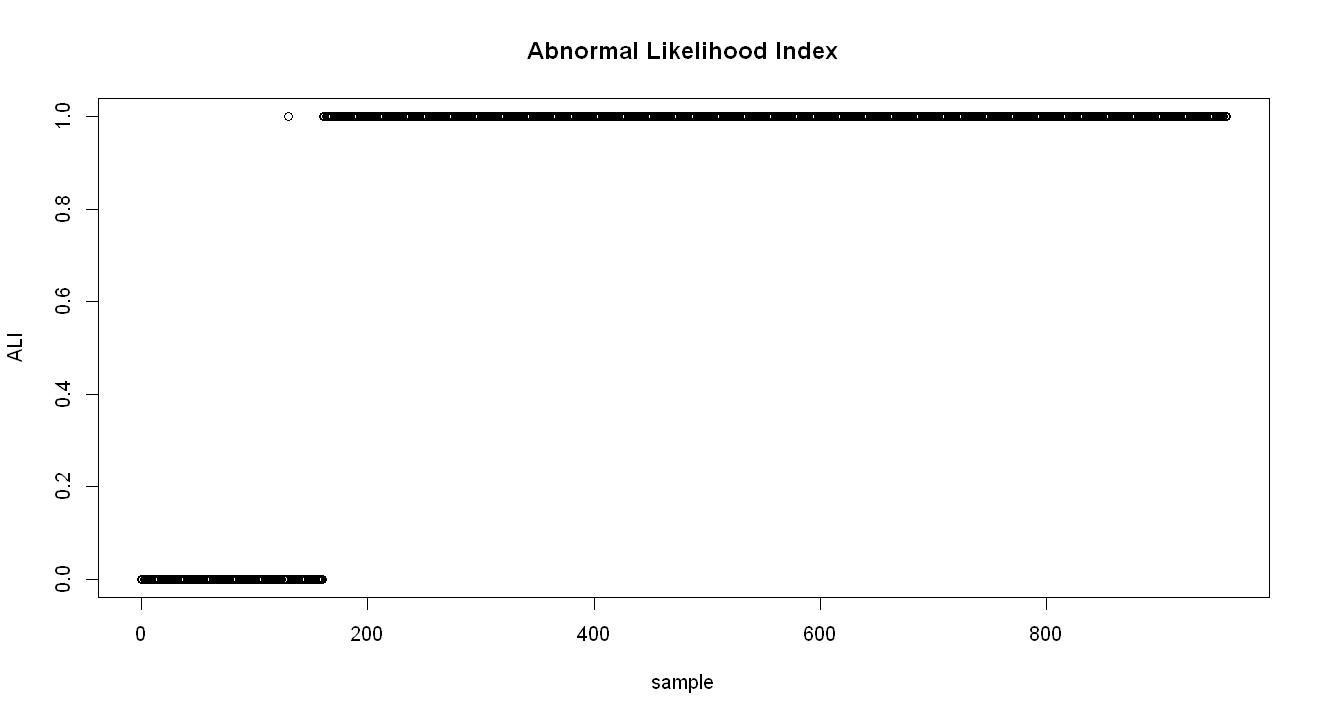

In [175]:
ALI(gaussian_total2, "7")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


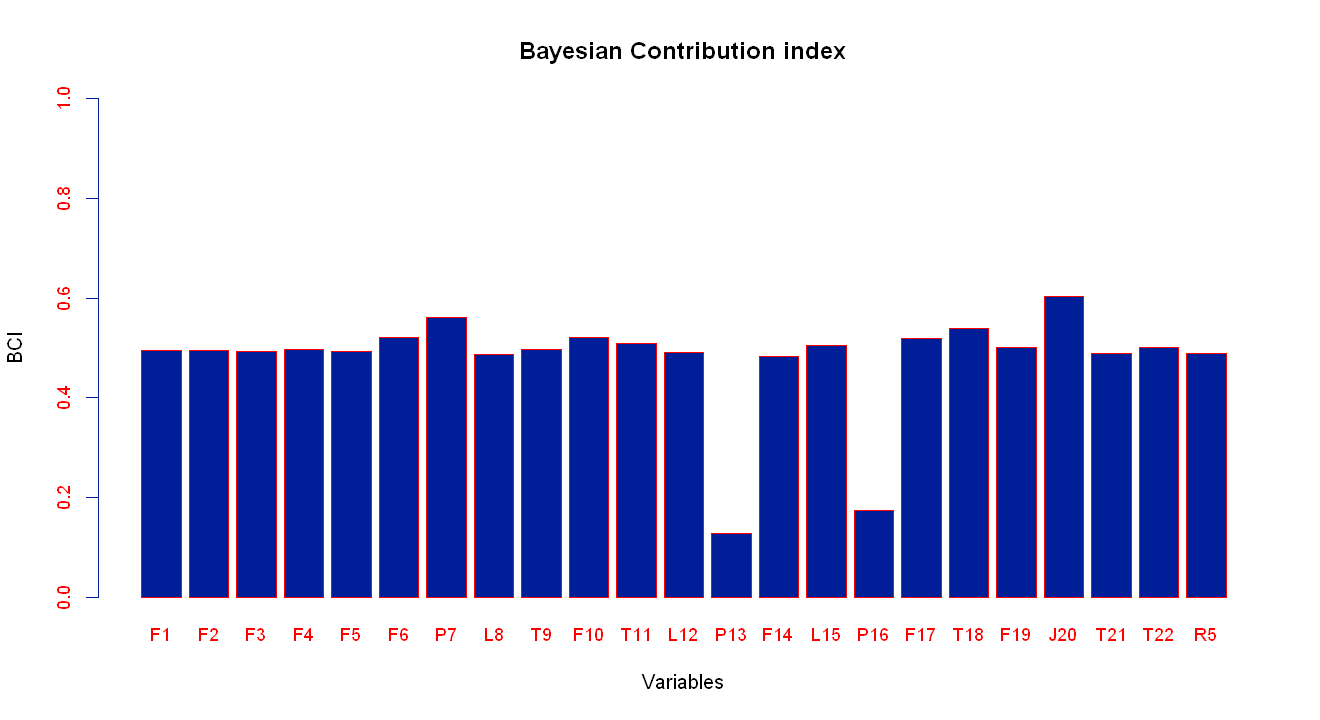

In [176]:
bci_7 = BCI(gaussian_total2, "default7", 161, 160)
bci_7

BCI_plot(bci_7)

<hr>

<span style="color:purple"><font size="5"><b>[IDV8] Given</b></font></span> 

Fault Occured at 161


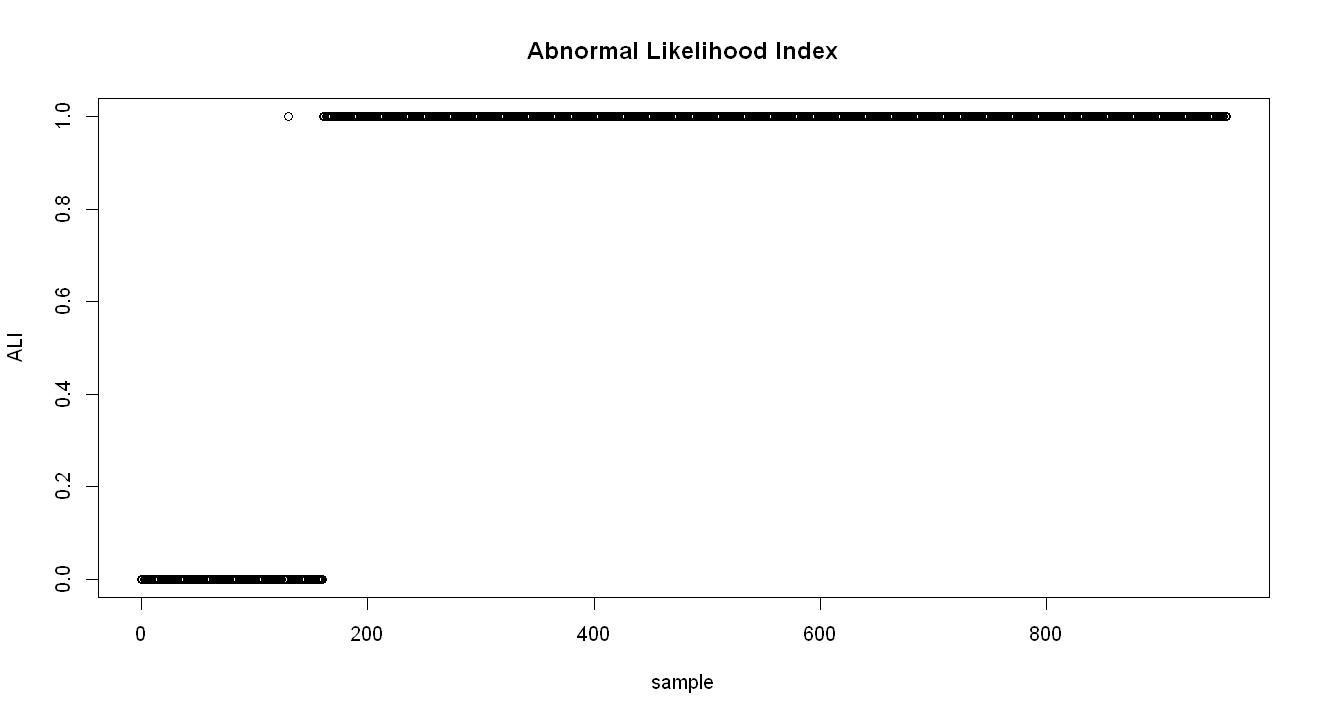

In [173]:
ALI(gaussian_total1, "8")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


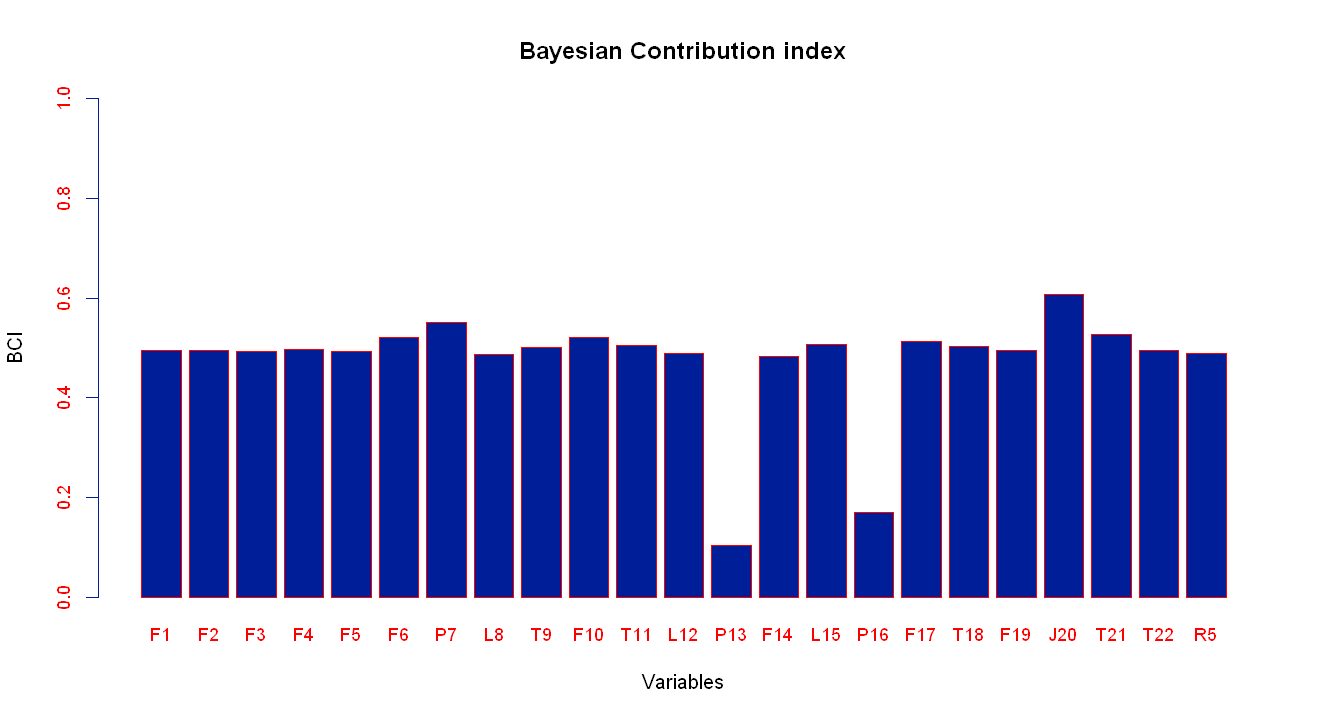

In [174]:
bci_8a = BCI(gaussian_total1, "default8", 161, 160)
bci_8a

BCI_plot(bci_8a)

<hr>

<span style="color:green"><font size="5"><b>[IDV8] Obtained</b></font></span> 

Fault Occured at 161


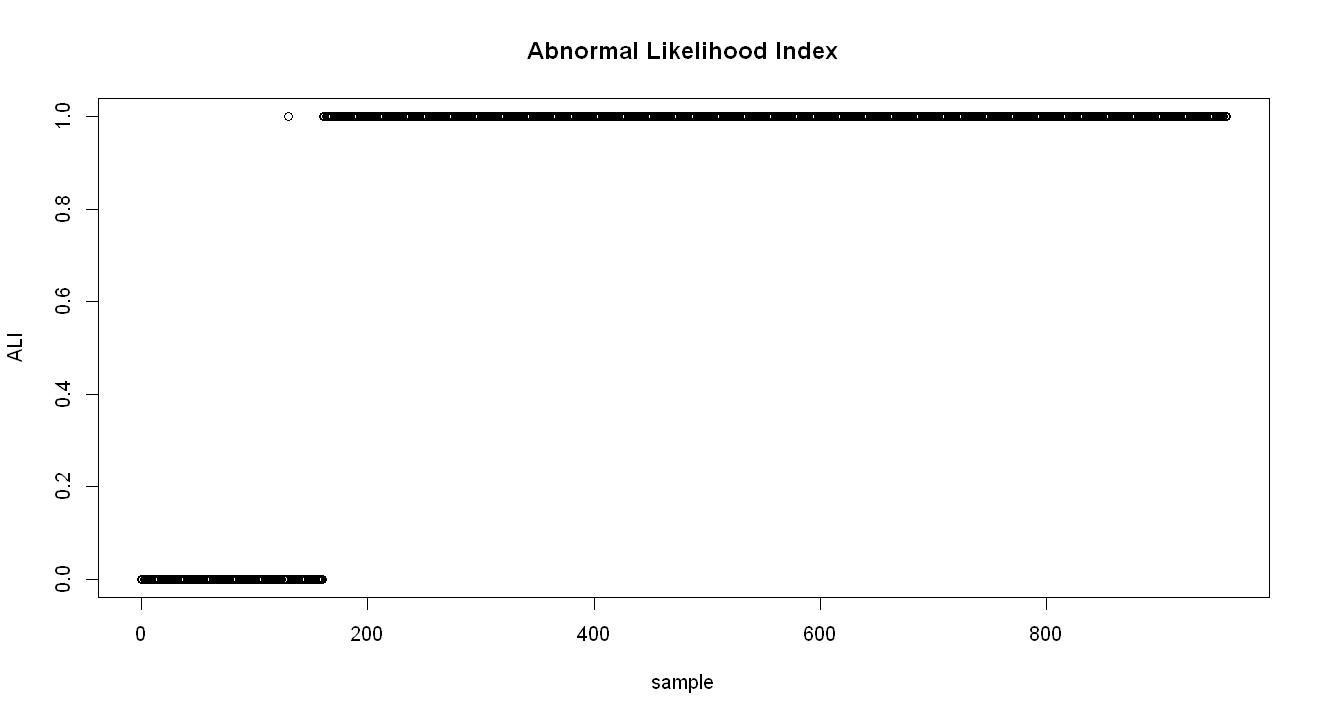

In [175]:
ALI(gaussian_total2, "8")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


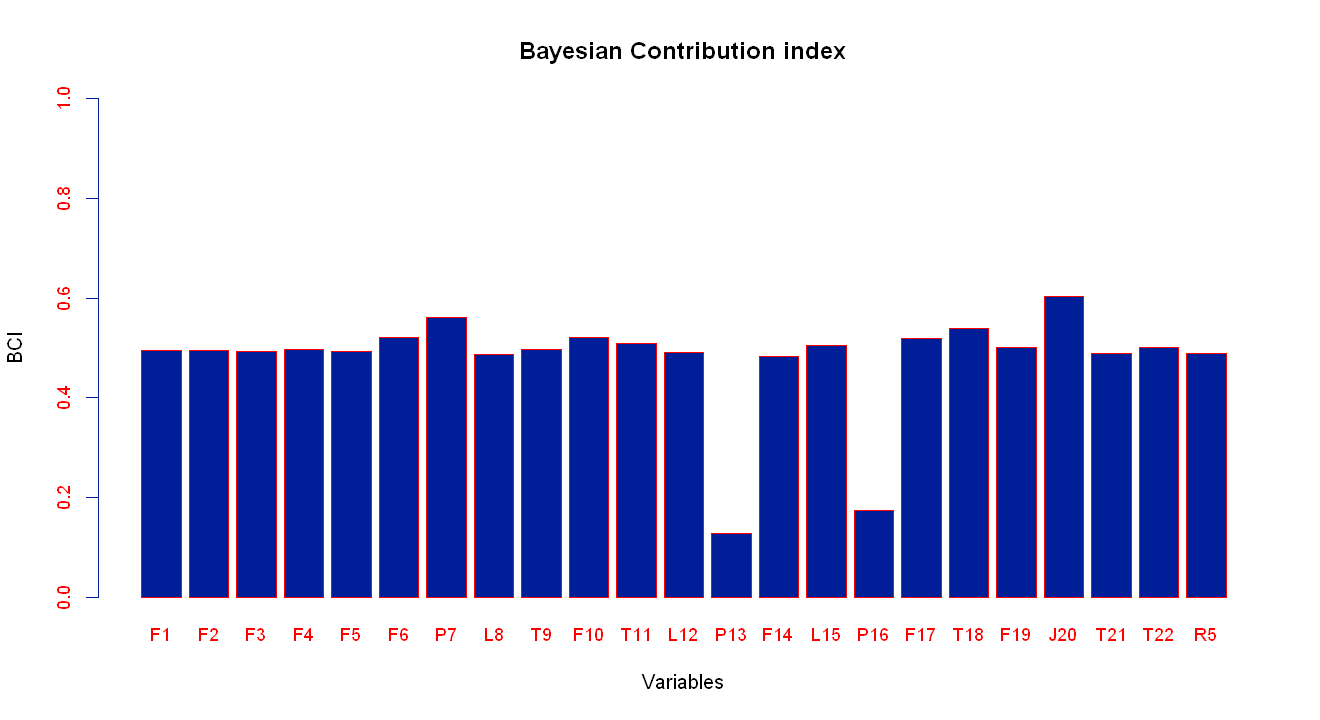

In [176]:
bci_8 = BCI(gaussian_total2, "default8", 161, 160)
bci_8

BCI_plot(bci_8)

<hr>

<span style="color:purple"><font size="5"><b>[IDV9] Given</b></font></span> 

Fault Occured at 161


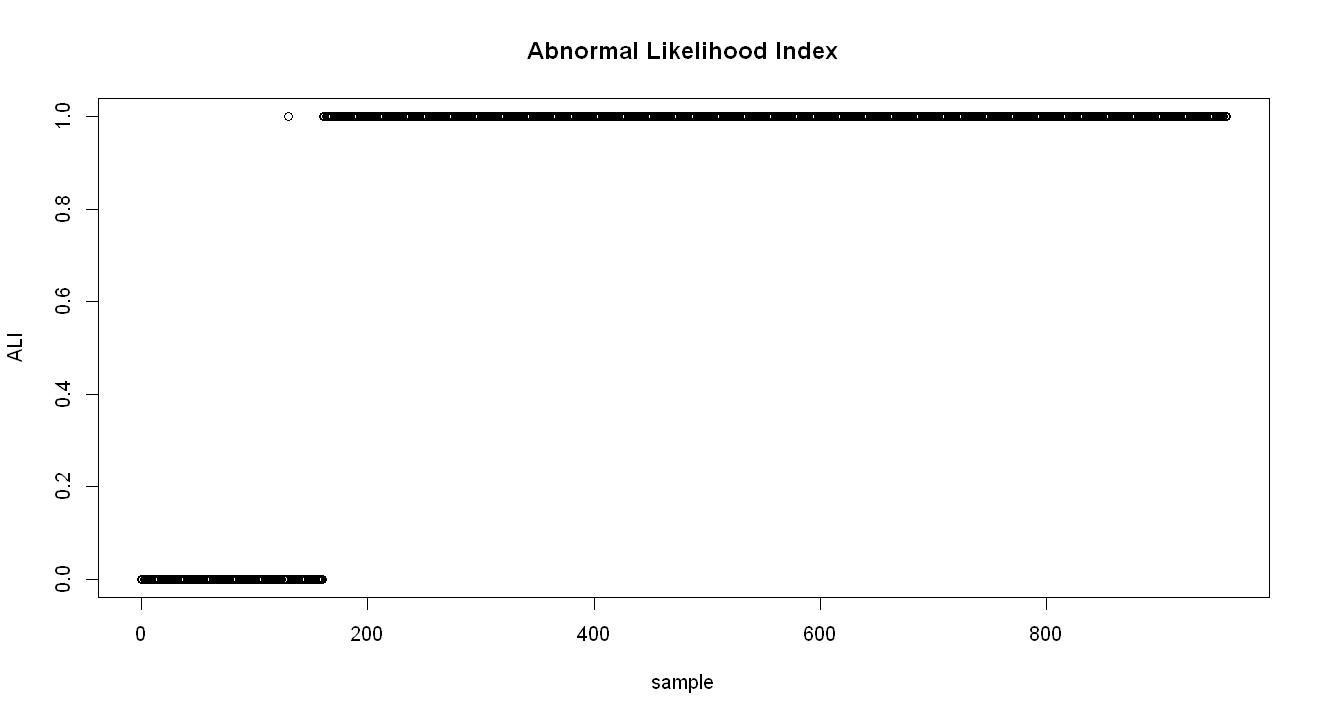

In [173]:
ALI(gaussian_total1, "9")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


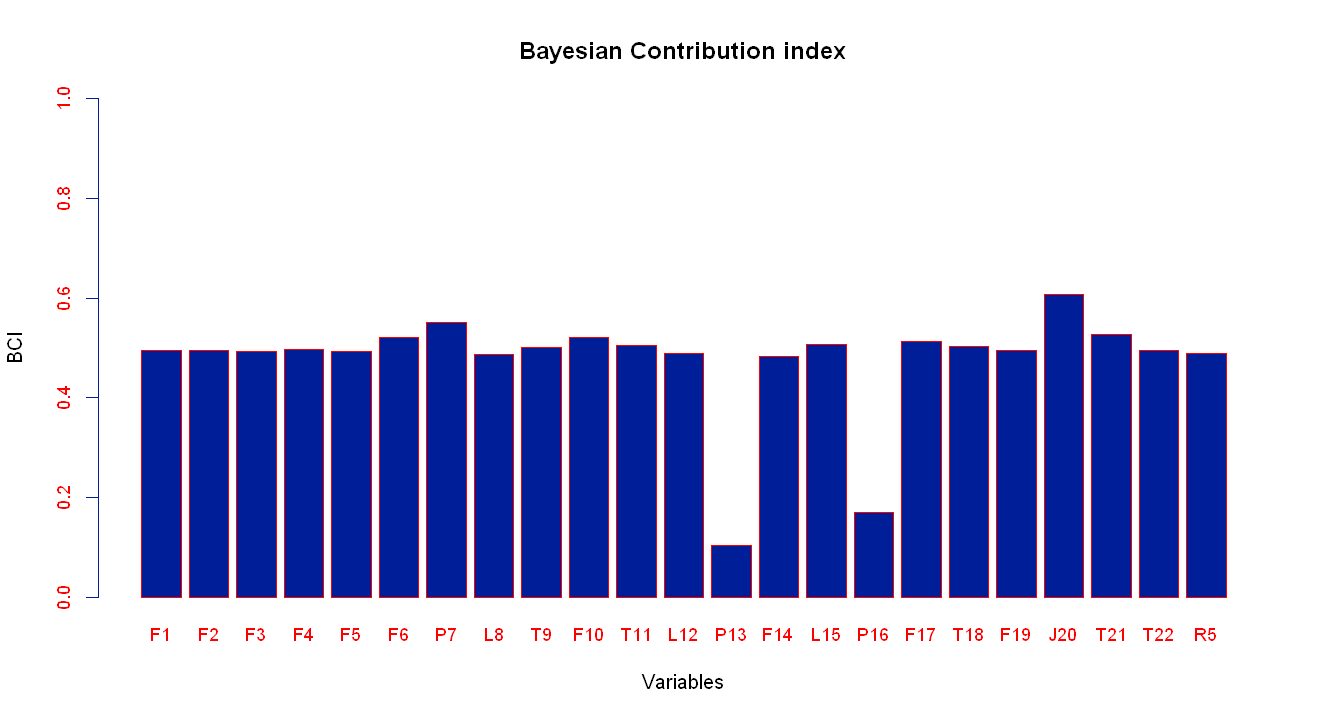

In [174]:
bci_9a = BCI(gaussian_total1, "default9", 161, 160)
bci_9a

BCI_plot(bci_9a)

<hr>

<span style="color:green"><font size="5"><b>[IDV9] Obtained</b></font></span> 

Fault Occured at 161


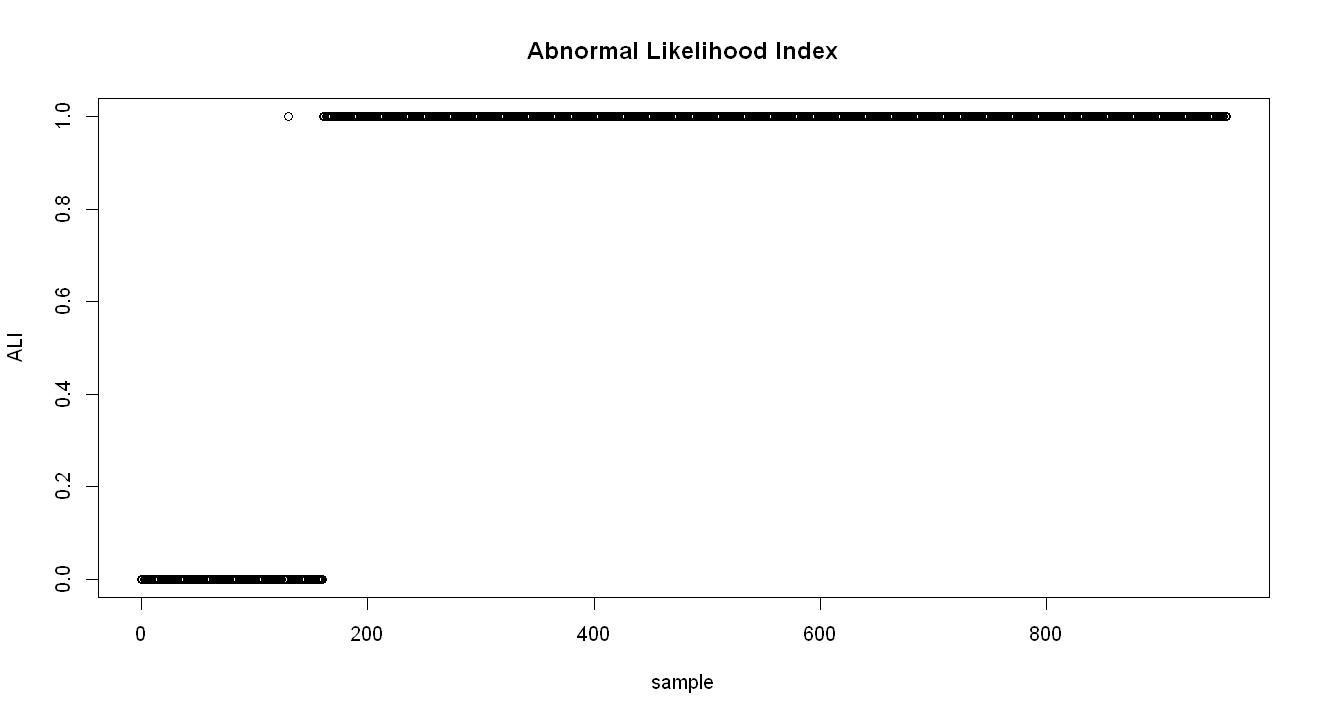

In [175]:
ALI(gaussian_total2, "9")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


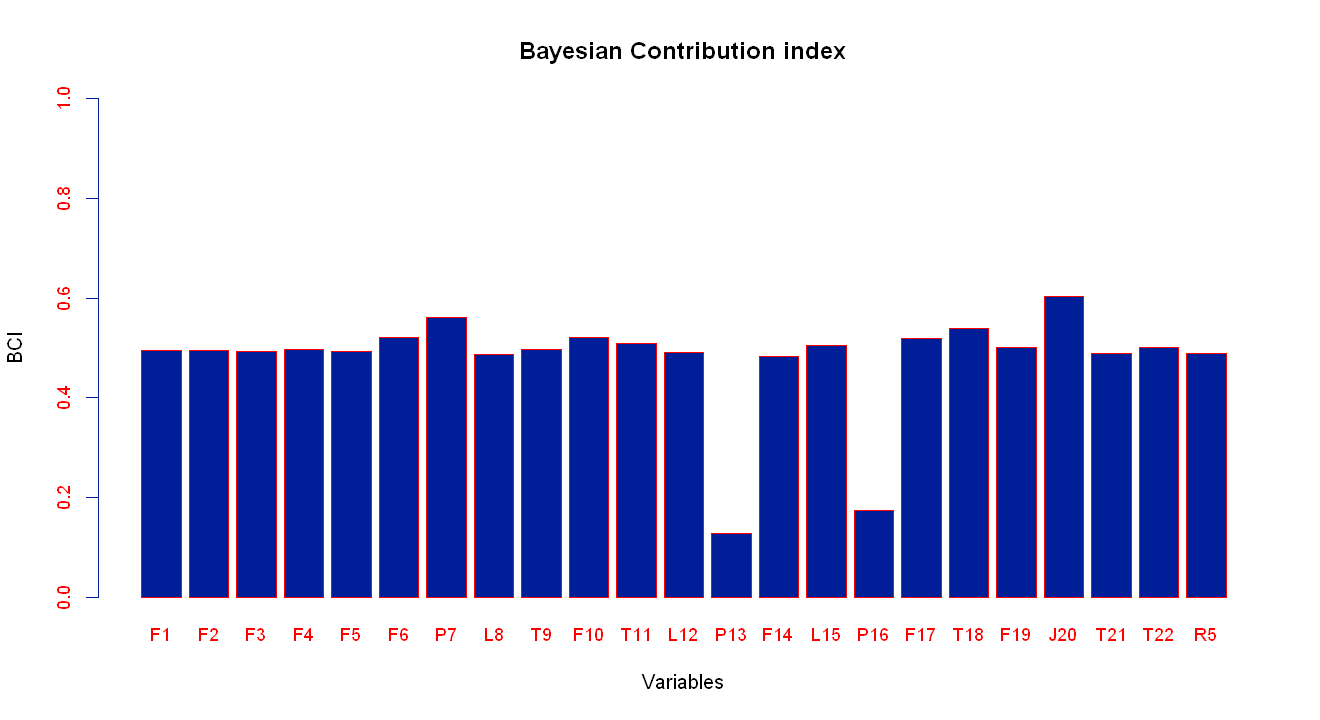

In [176]:
bci_9 = BCI(gaussian_total2, "default9", 161, 160)
bci_9

BCI_plot(bci_9)

<hr>

<span style="color:purple"><font size="5"><b>[IDV10] Given</b></font></span> 

Fault Occured at 161


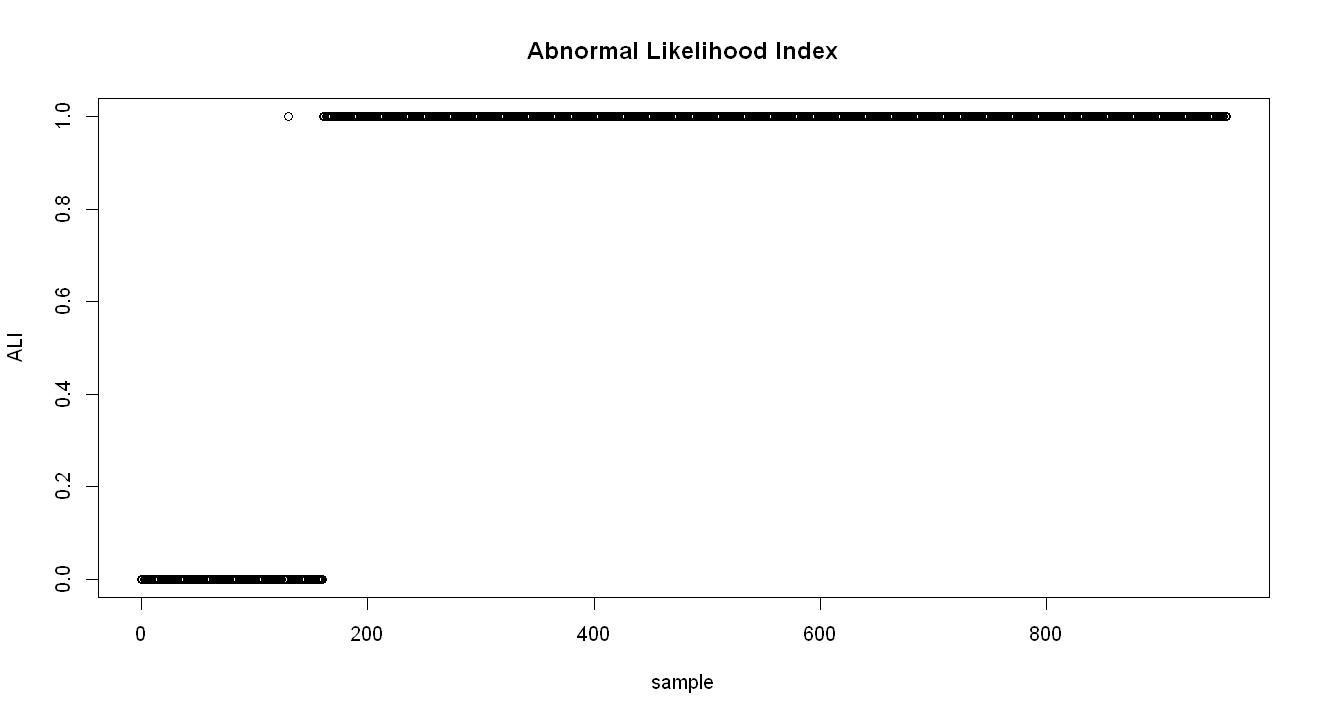

In [173]:
ALI(gaussian_total1, "10")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


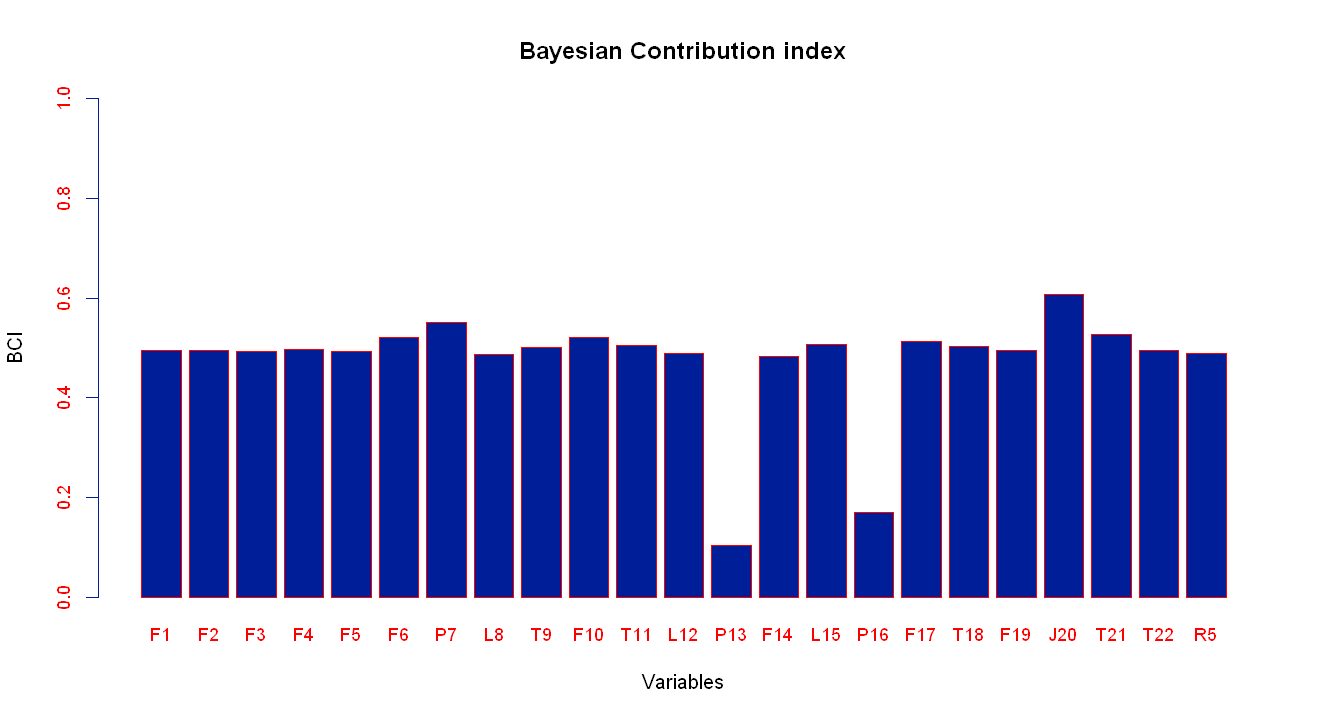

In [174]:
bci_10a = BCI(gaussian_total1, "default10", 161, 160)
bci_10a

BCI_plot(bci_10a)

<hr>

<span style="color:green"><font size="5"><b>[IDV10] Obtained</b></font></span> 

Fault Occured at 161


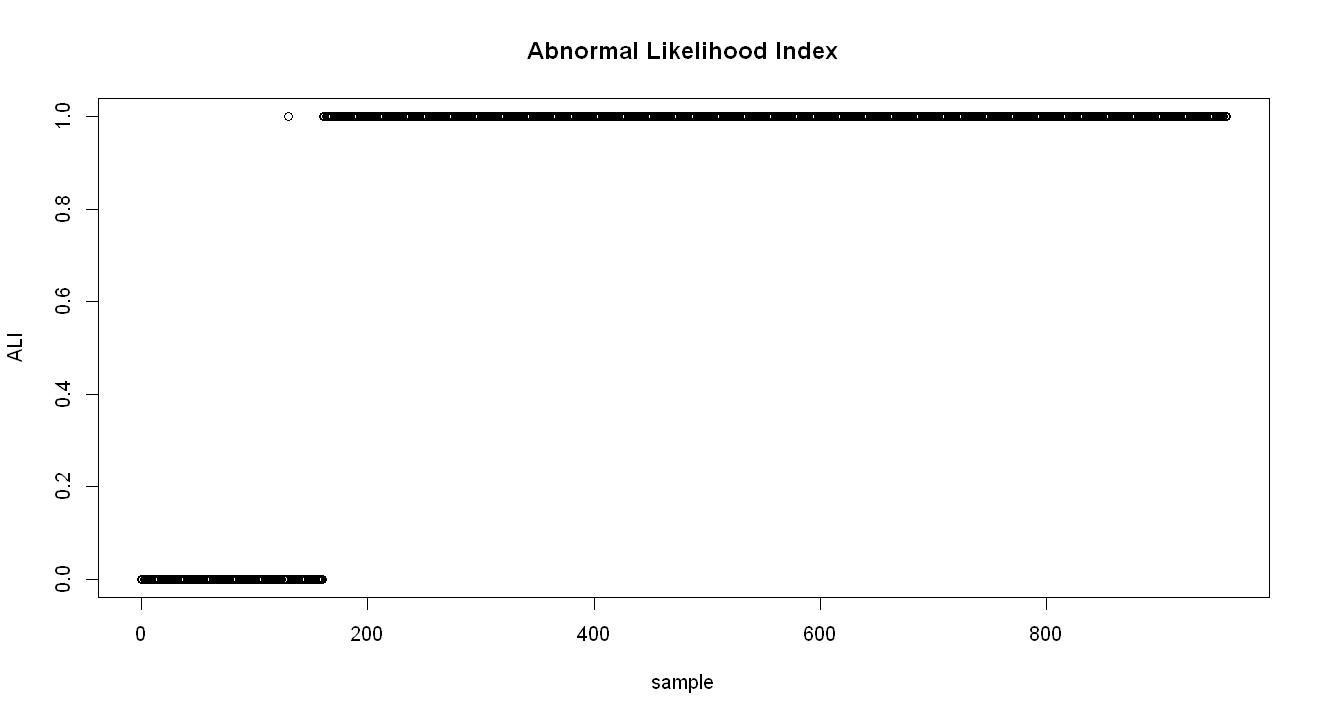

In [175]:
ALI(gaussian_total2, "10")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


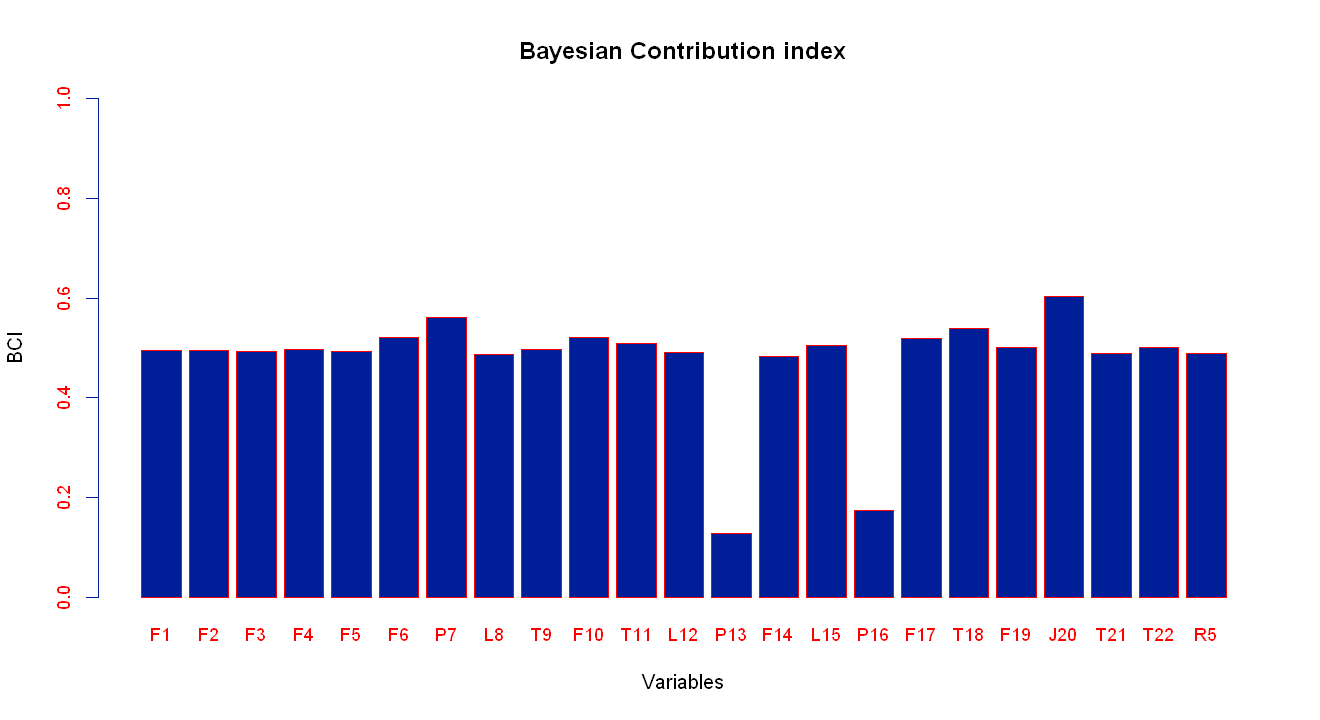

In [176]:
bci_10 = BCI(gaussian_total2, "default10", 161, 160)
bci_10

BCI_plot(bci_10)

<hr>

<span style="color:purple"><font size="5"><b>[IDV11] Given</b></font></span> 

Fault Occured at 161


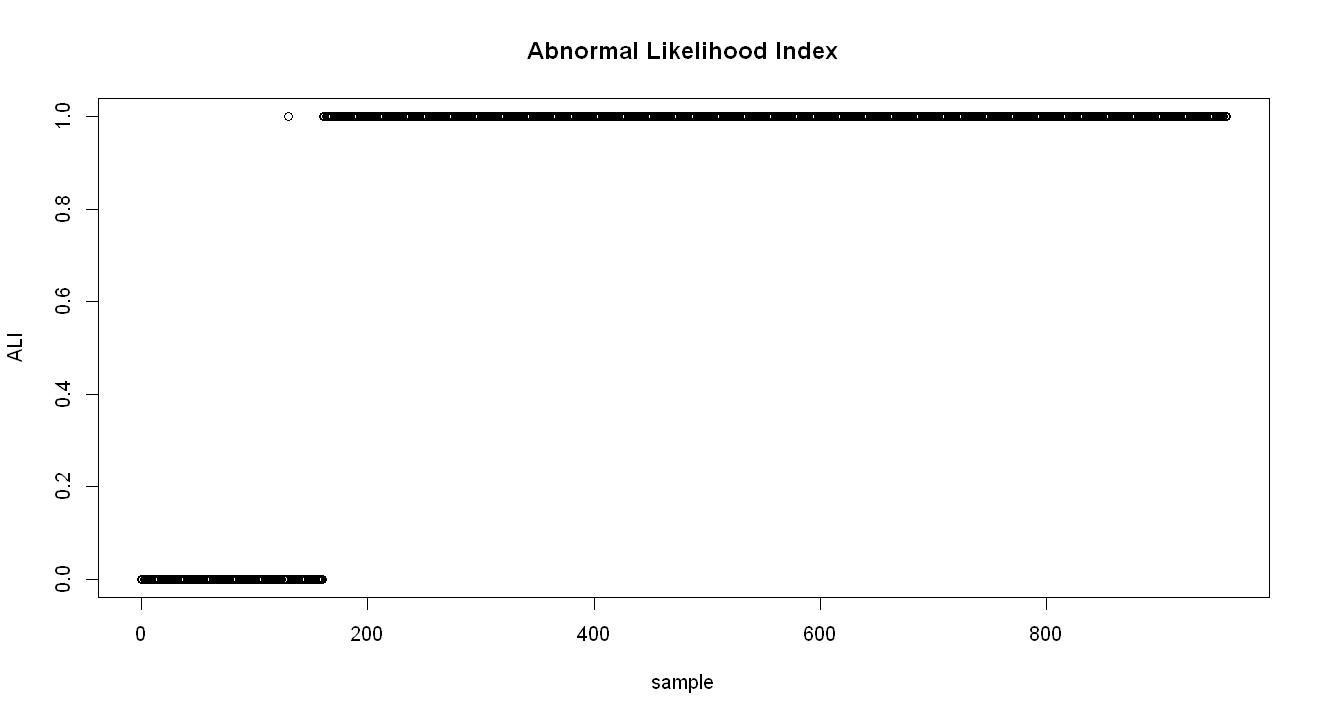

In [173]:
ALI(gaussian_total1, "11")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


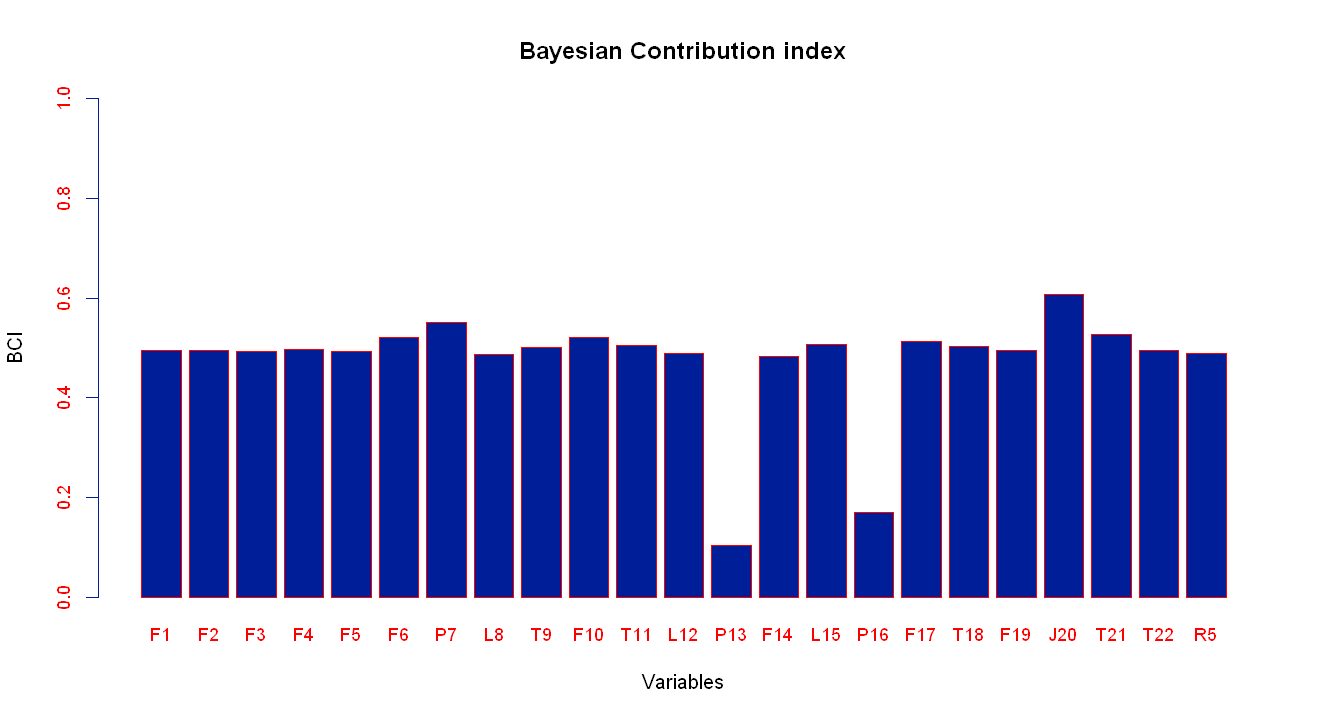

In [174]:
bci_11a = BCI(gaussian_total1, "default11", 161, 160)
bci_11a

BCI_plot(bci_11a)

<hr>

<span style="color:green"><font size="5"><b>[IDV11] Obtained</b></font></span> 

Fault Occured at 161


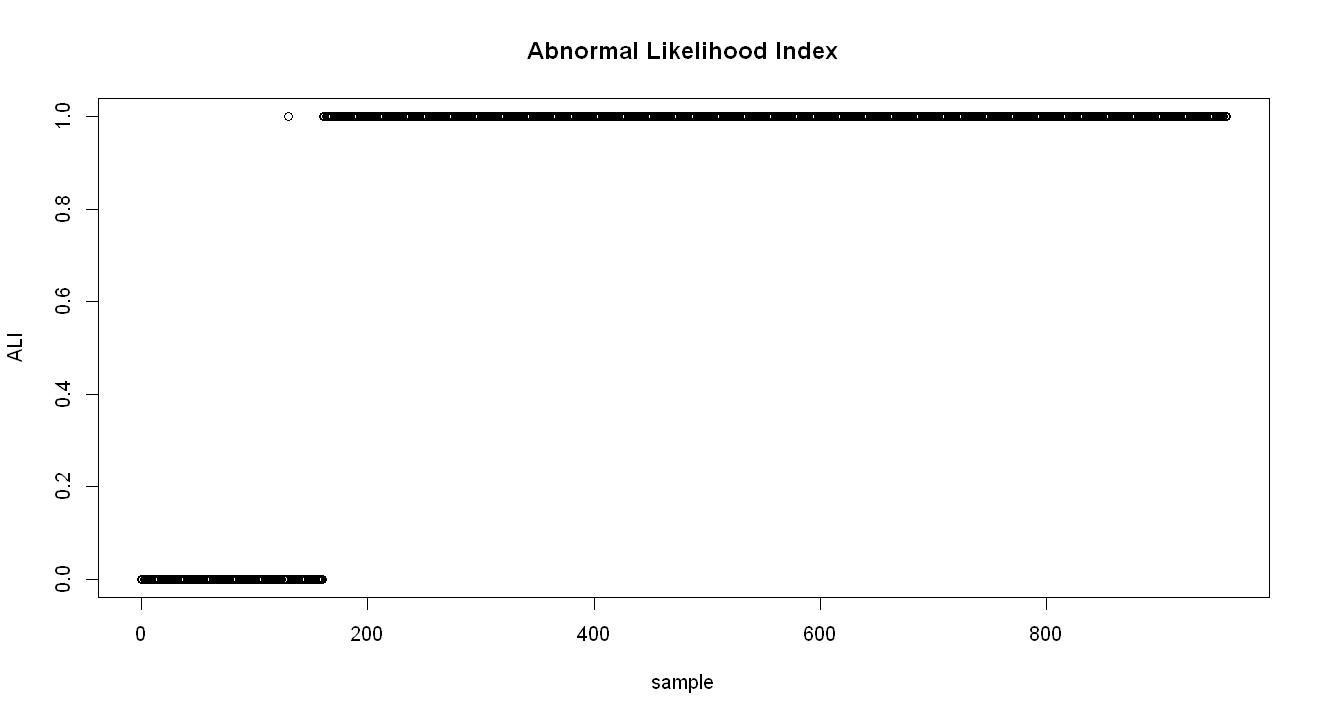

In [175]:
ALI(gaussian_total2, "11")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


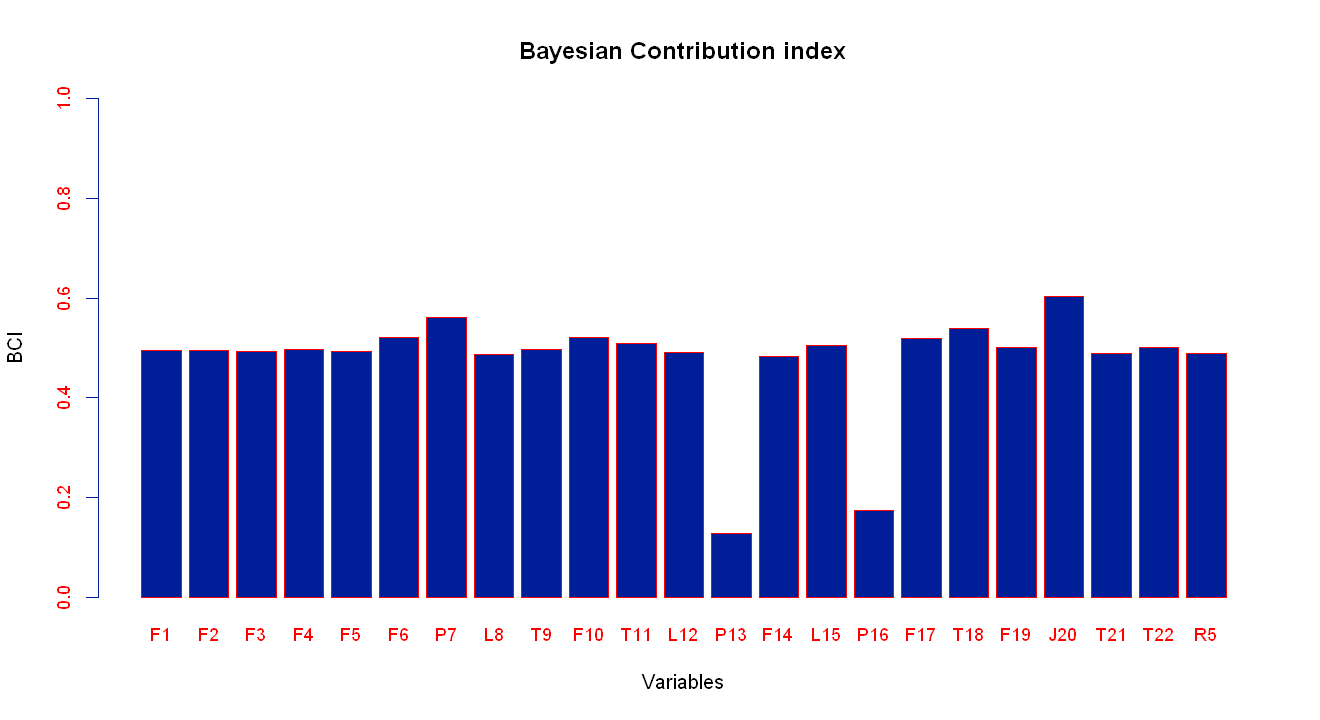

In [176]:
bci_11 = BCI(gaussian_total2, "default11", 161, 160)
bci_11

BCI_plot(bci_11)

<hr>

<span style="color:purple"><font size="5"><b>[IDV12] Given</b></font></span> 

Fault Occured at 161


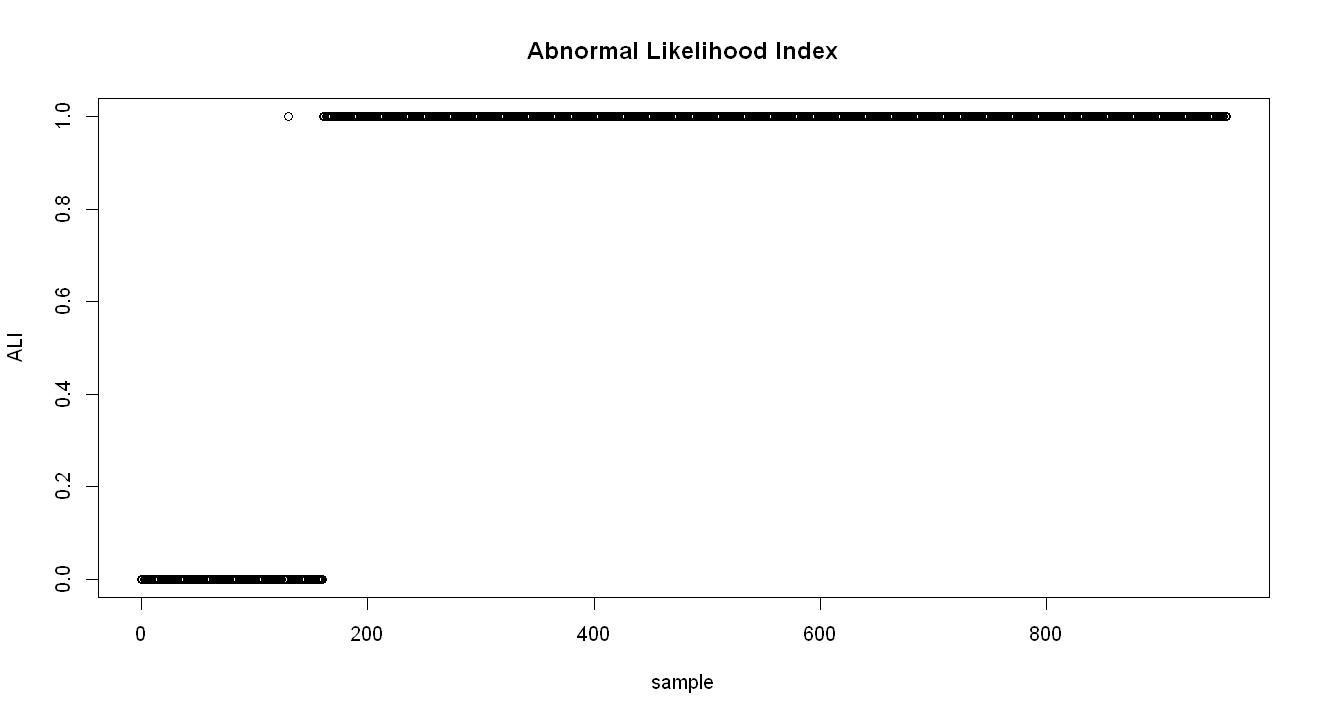

In [173]:
ALI(gaussian_total1, "12")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


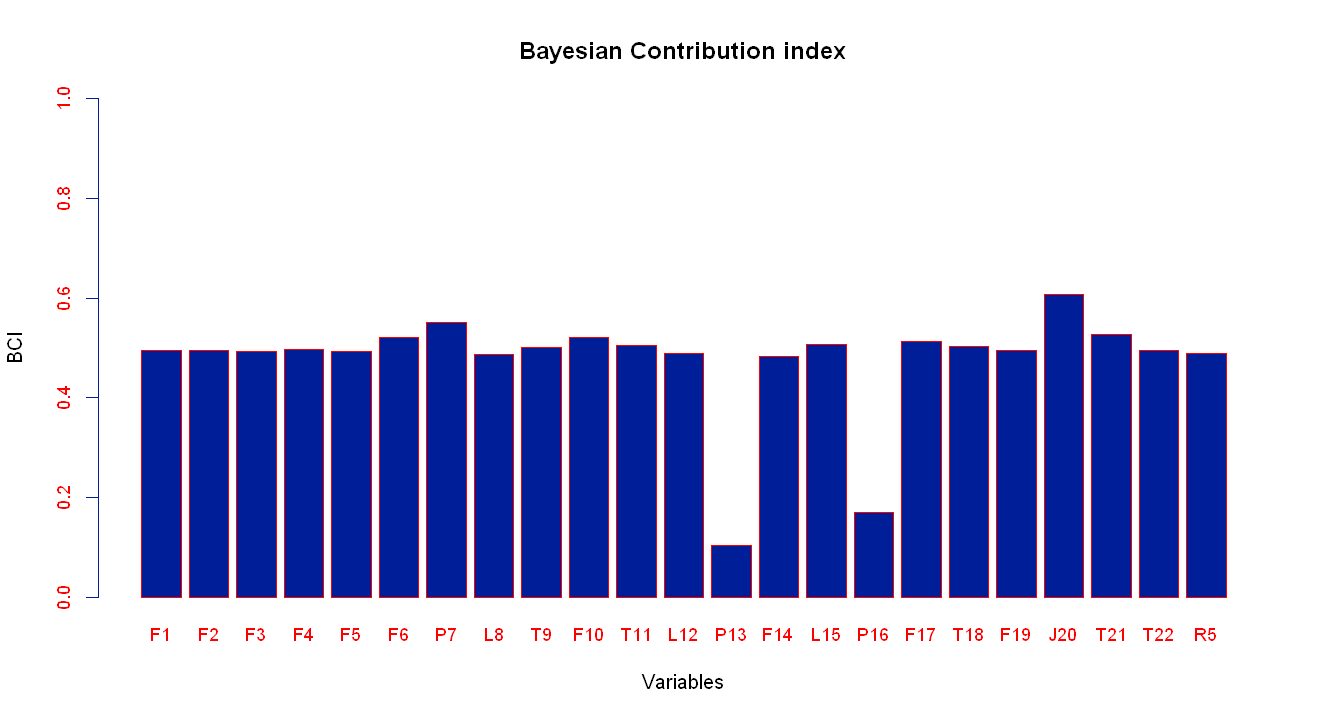

In [174]:
bci_12a = BCI(gaussian_total1, "default12", 161, 160)
bci_12a

BCI_plot(bci_12a)

<hr>

<span style="color:green"><font size="5"><b>[IDV12] Obtained</b></font></span> 

Fault Occured at 161


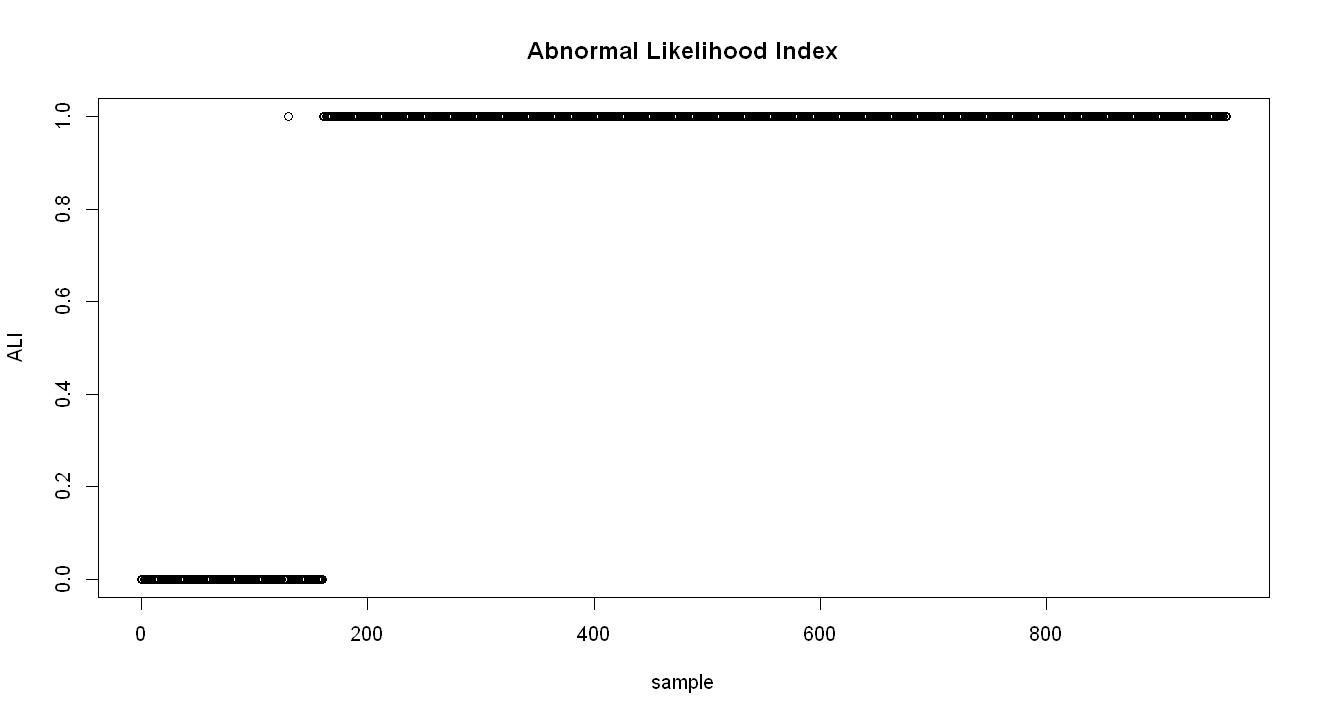

In [175]:
ALI(gaussian_total2, "12")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


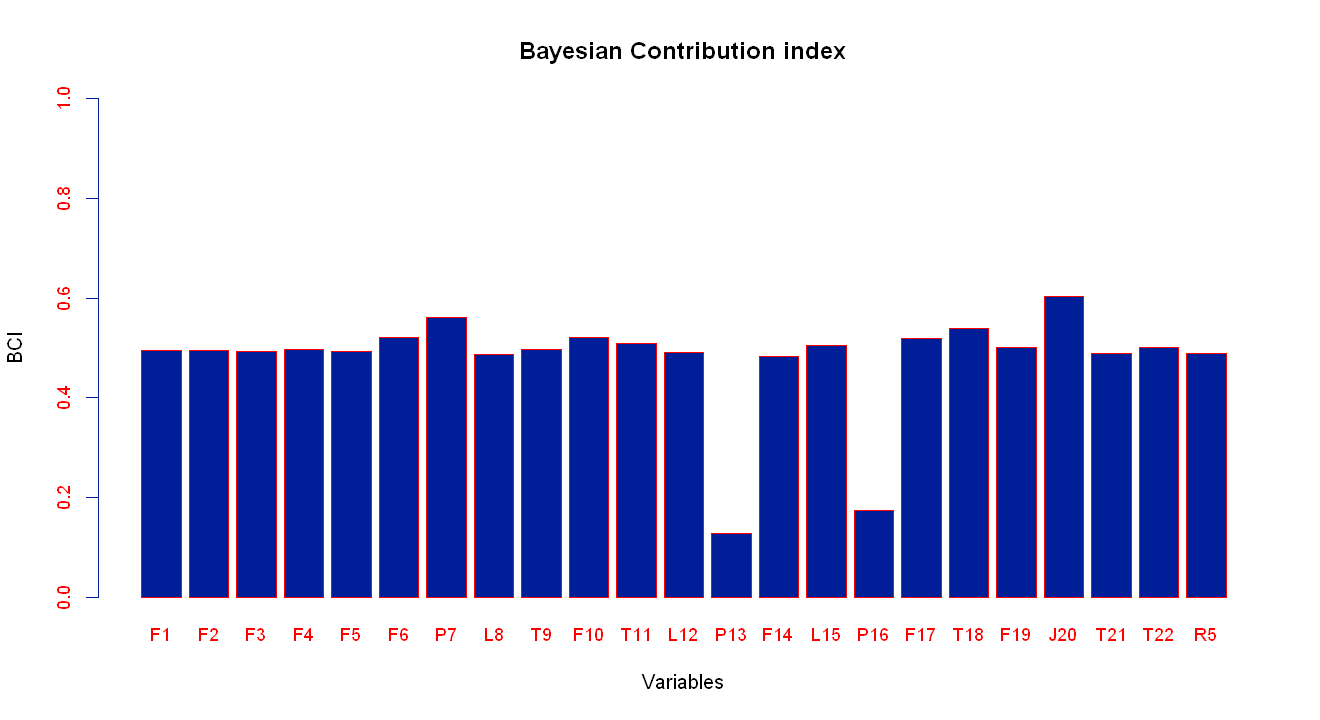

In [176]:
bci_12 = BCI(gaussian_total2, "default12", 161, 160)
bci_12

BCI_plot(bci_12)

<hr>

<span style="color:purple"><font size="5"><b>[IDV13] Given</b></font></span> 

Fault Occured at 161


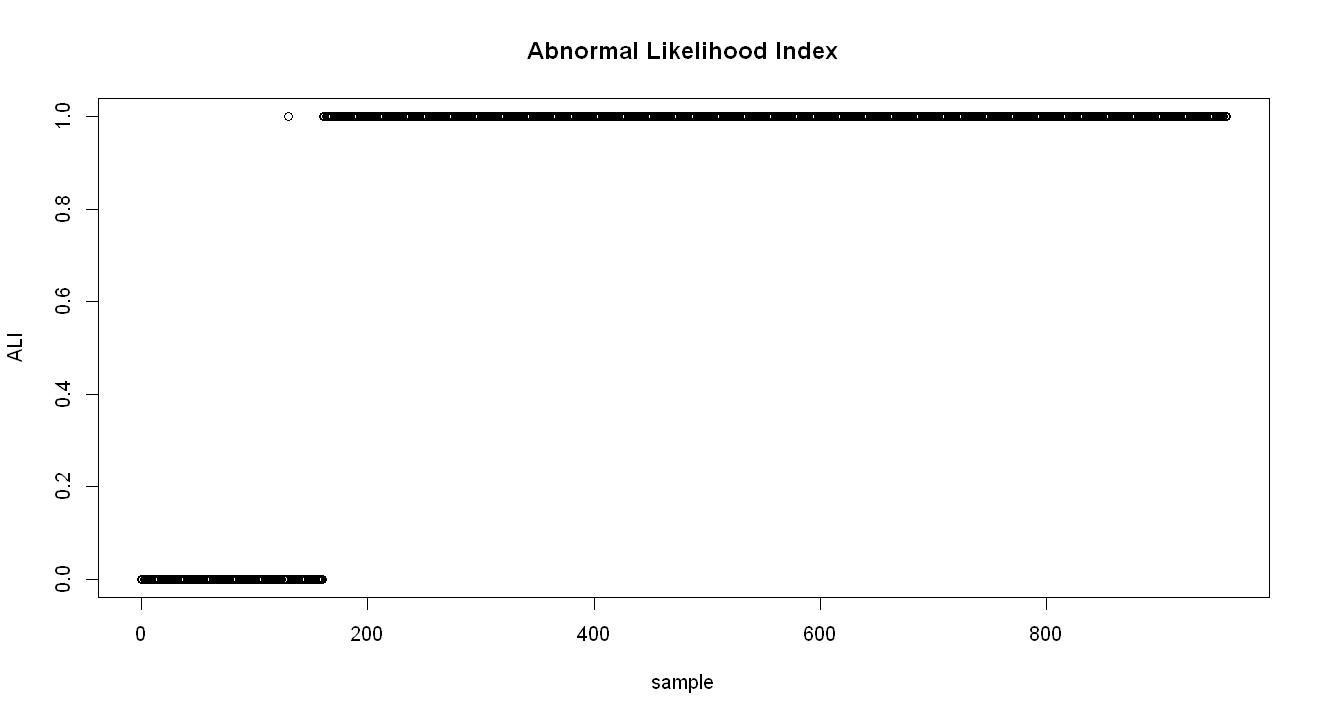

In [173]:
ALI(gaussian_total1, "13")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


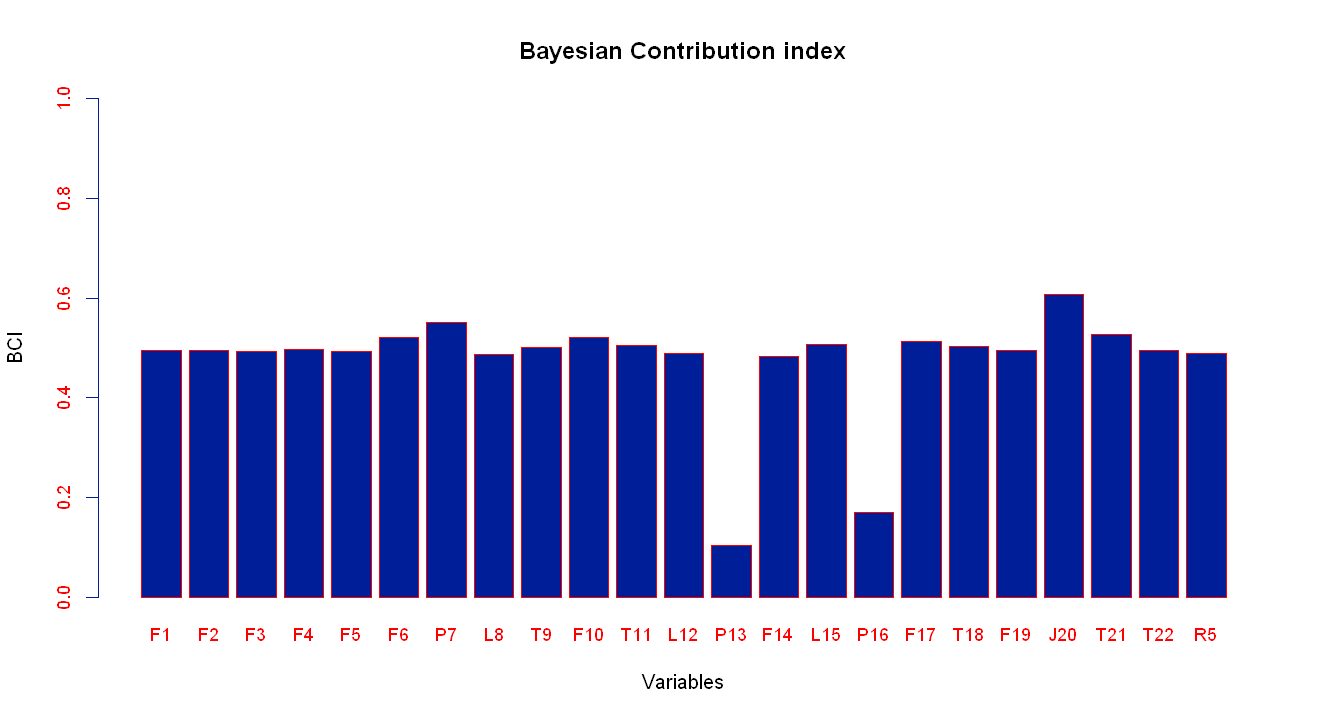

In [174]:
bci_13a = BCI(gaussian_total1, "default13", 161, 160)
bci_13a

BCI_plot(bci_13a)

<hr>

<span style="color:green"><font size="5"><b>[IDV13] Obtained</b></font></span> 

Fault Occured at 161


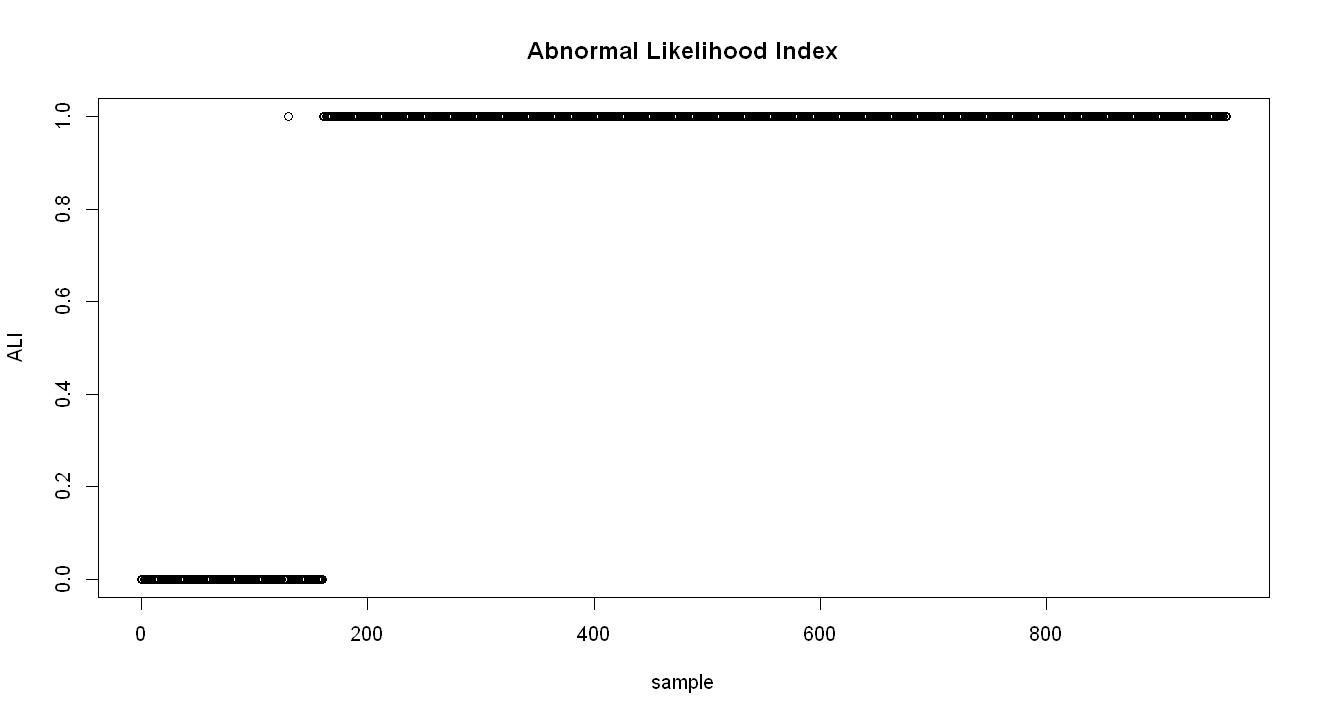

In [175]:
ALI(gaussian_total2, "13")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


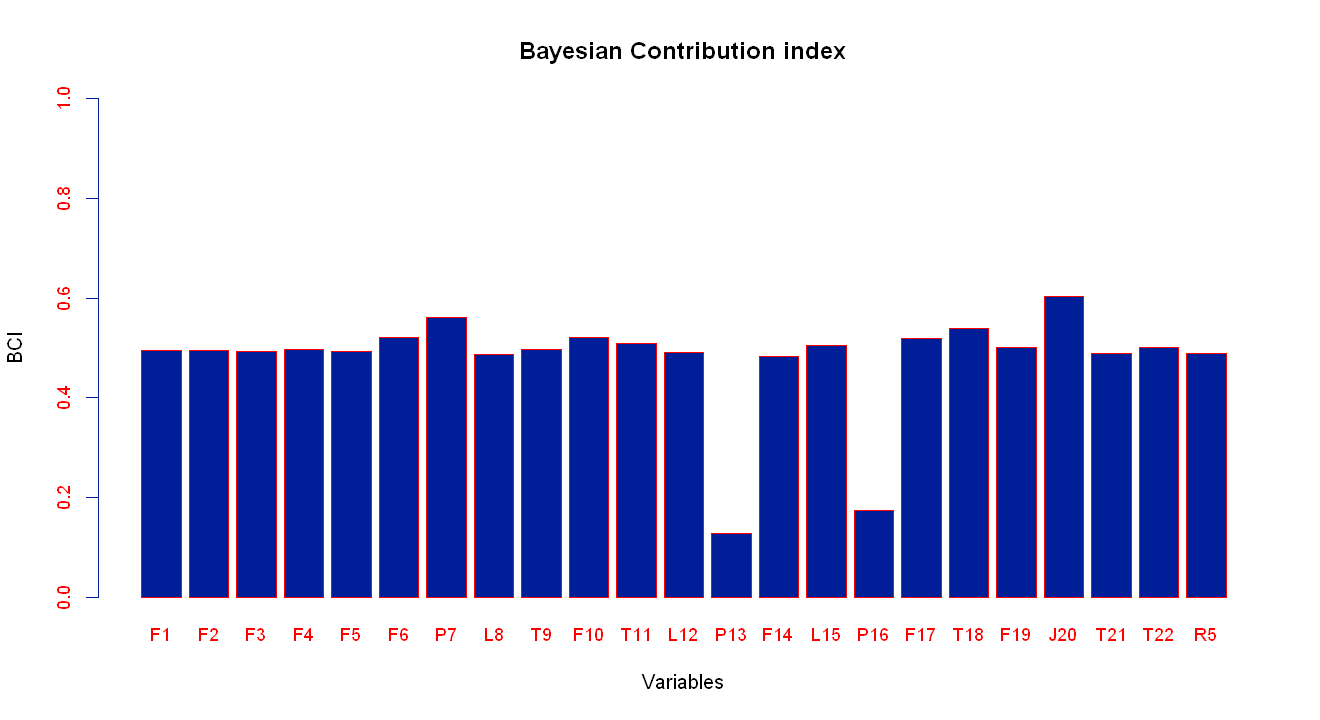

In [176]:
bci_13 = BCI(gaussian_total2, "default13", 161, 160)
bci_13

BCI_plot(bci_13)

<hr>

<span style="color:purple"><font size="5"><b>[IDV14] Given</b></font></span> 

Fault Occured at 161


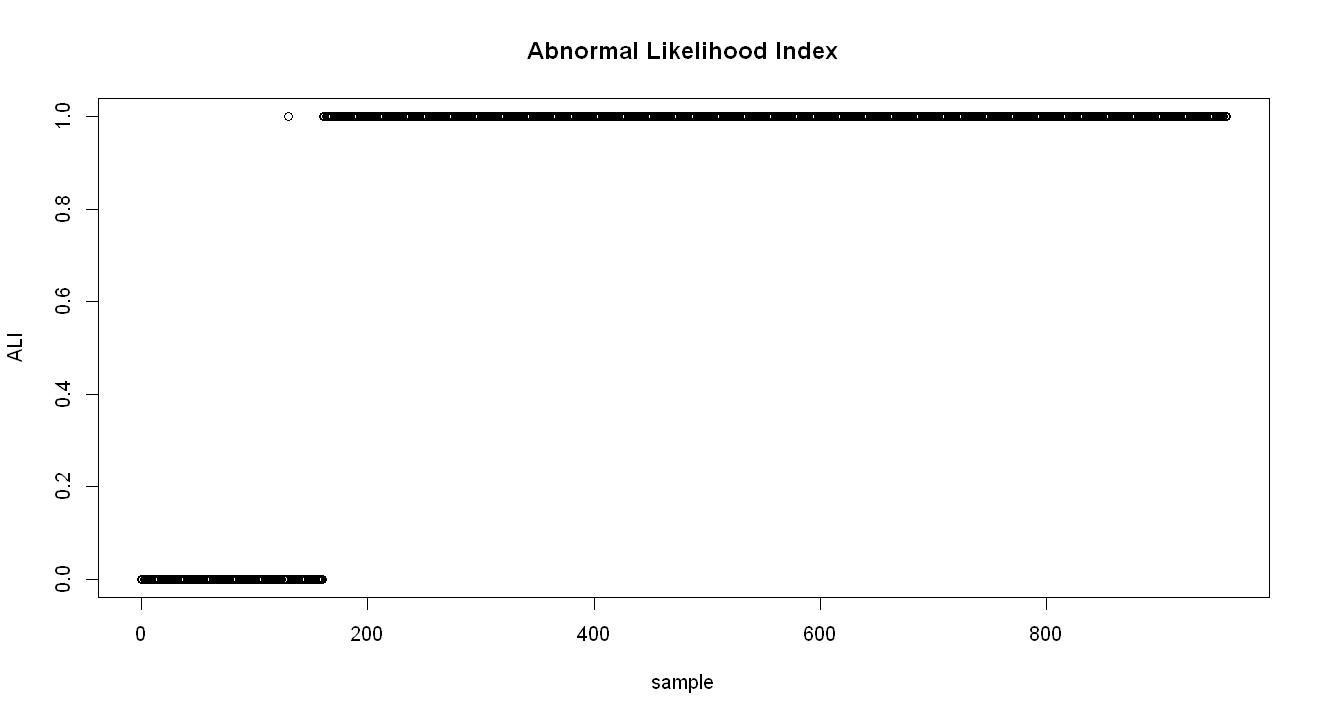

In [173]:
ALI(gaussian_total1, "14")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


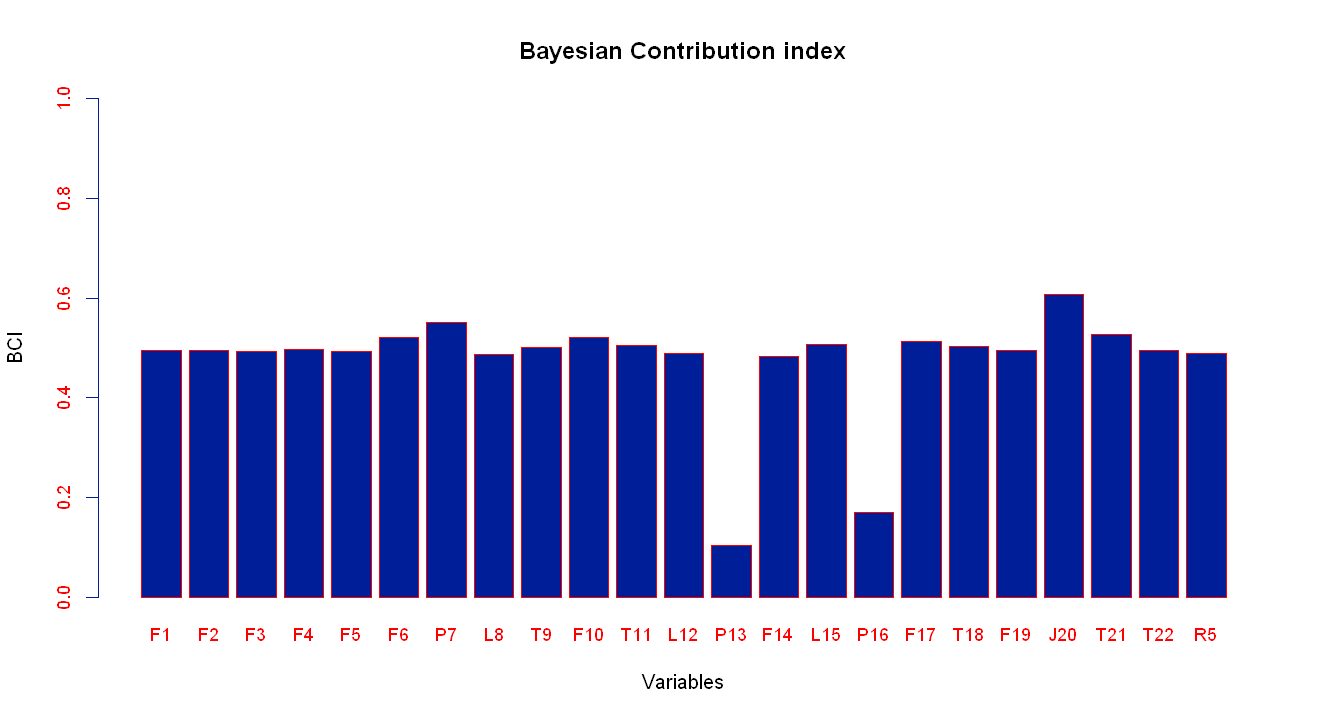

In [174]:
bci_14a = BCI(gaussian_total1, "default14", 161, 160)
bci_14a

BCI_plot(bci_14a)

<hr>

<span style="color:green"><font size="5"><b>[IDV14] Obtained</b></font></span> 

Fault Occured at 161


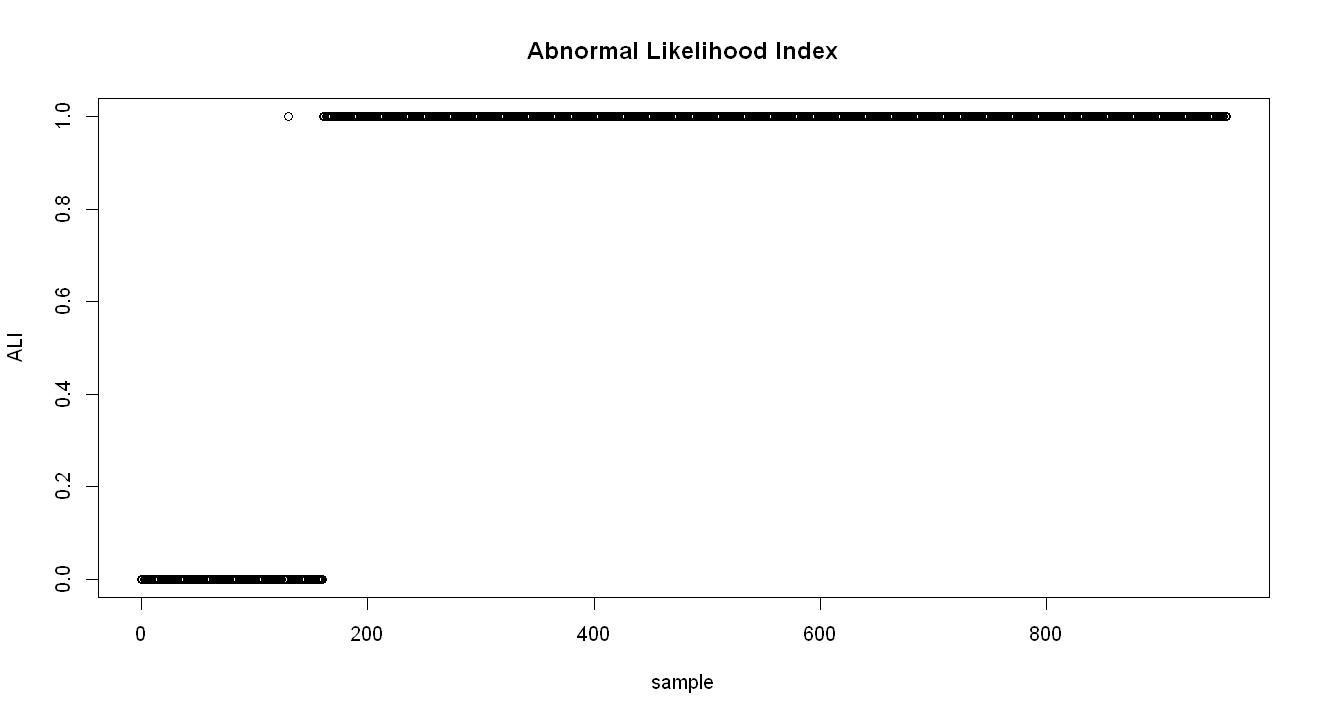

In [175]:
ALI(gaussian_total2, "14")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


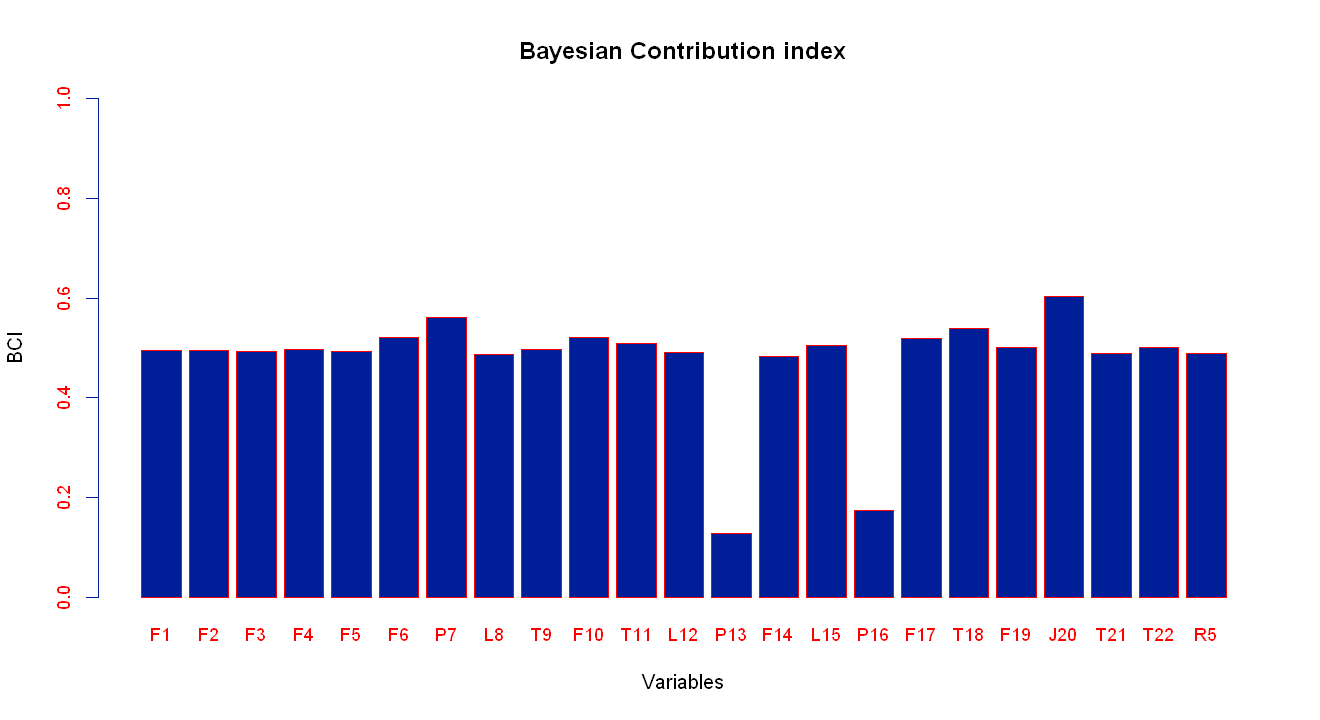

In [176]:
bci_14 = BCI(gaussian_total2, "default14", 161, 160)
bci_14

BCI_plot(bci_14)

<hr>

<span style="color:purple"><font size="5"><b>[IDV15] Given</b></font></span> 

Fault Occured at 161


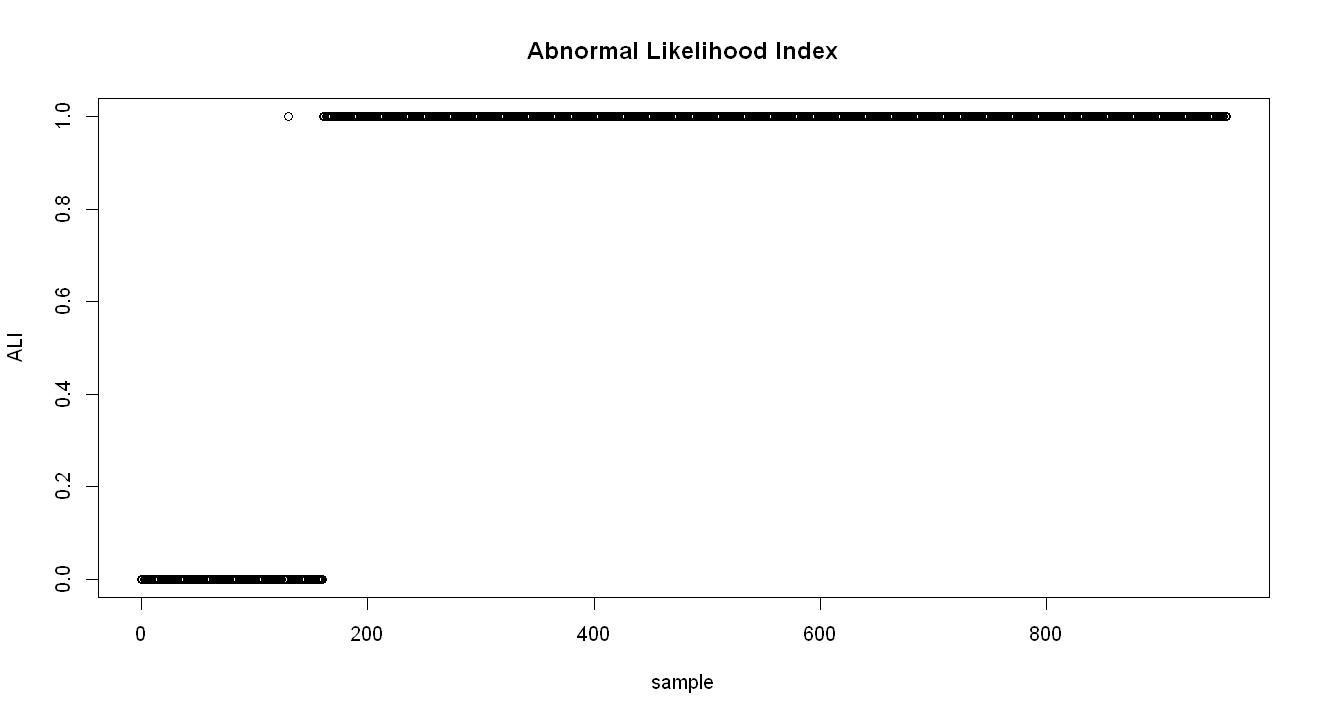

In [173]:
ALI(gaussian_total1, "15")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


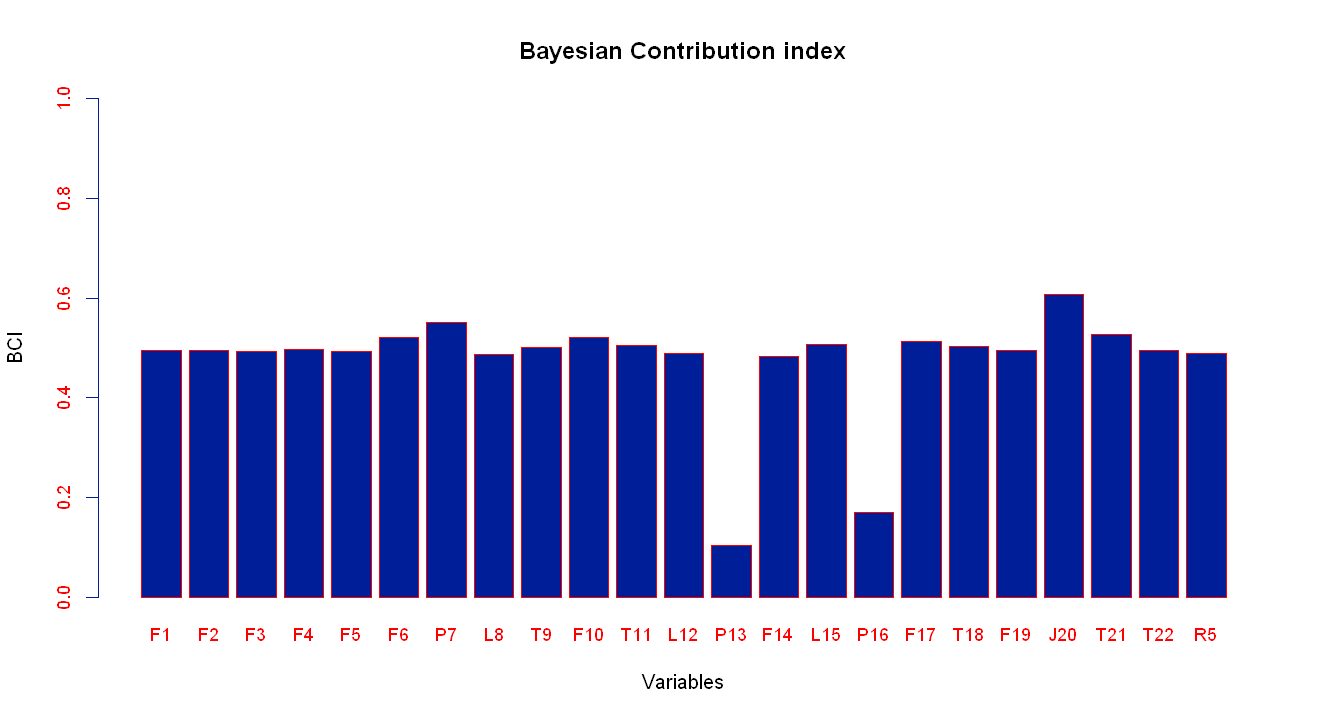

In [174]:
bci_15a = BCI(gaussian_total1, "default15", 161, 160)
bci_15a

BCI_plot(bci_15a)

<hr>

<span style="color:green"><font size="5"><b>[IDV15] Obtained</b></font></span> 

Fault Occured at 161


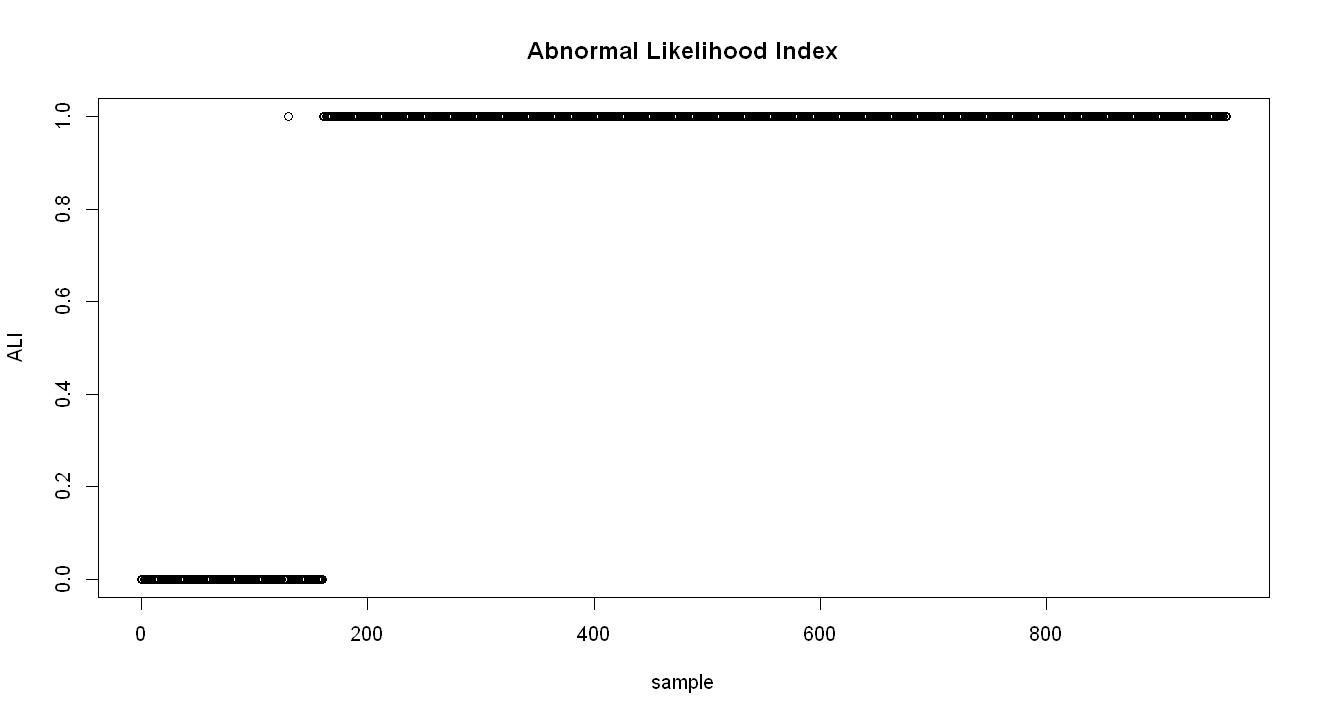

In [175]:
ALI(gaussian_total2, "15")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


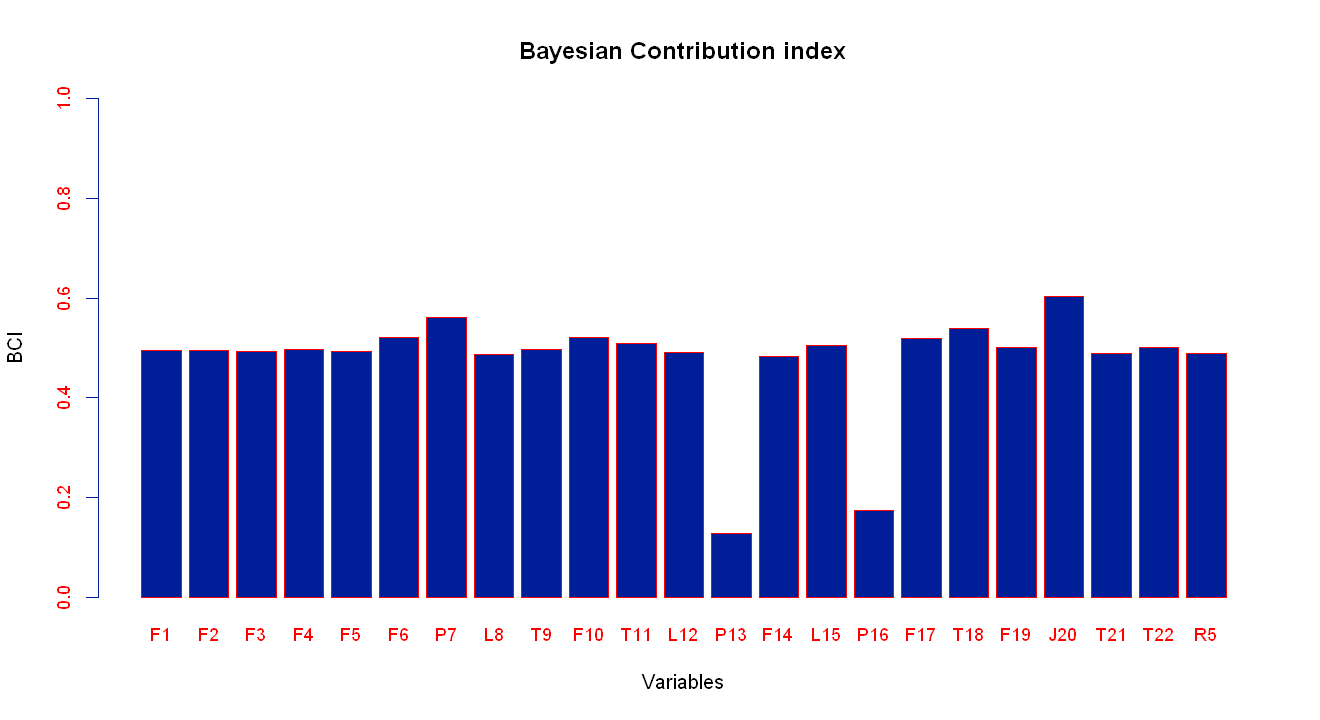

In [176]:
bci_15 = BCI(gaussian_total2, "default15", 161, 160)
bci_15

BCI_plot(bci_15)

<hr>

<span style="color:purple"><font size="5"><b>[IDV16] Given</b></font></span> 

Fault Occured at 161


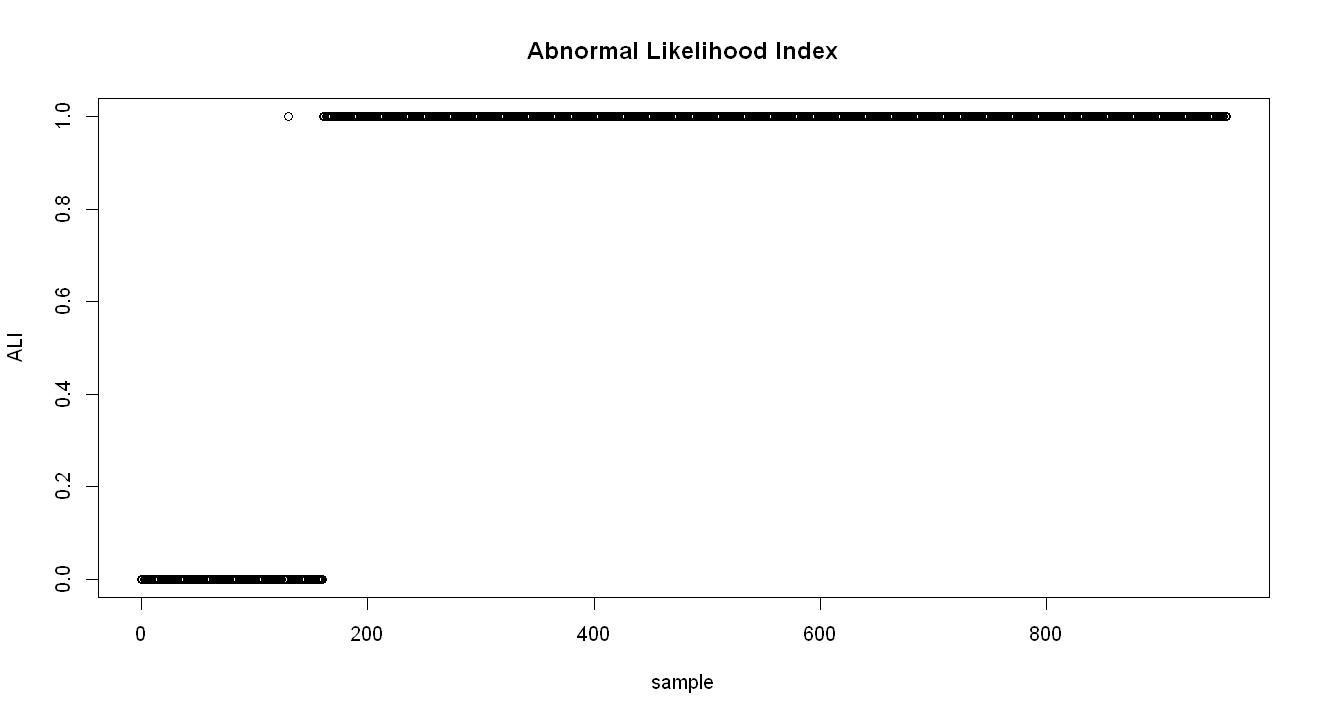

In [173]:
ALI(gaussian_total1, "16")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.495094,0.4940361,0.4924913,0.4975459,0.4932333,0.5202141,0.5512181,0.4873194,0.5005331,0.5213549,...,0.4831153,0.5061478,0.1699648,0.5135149,0.5023036,0.4950345,0.6067311,0.5274916,0.494311,0.4889751


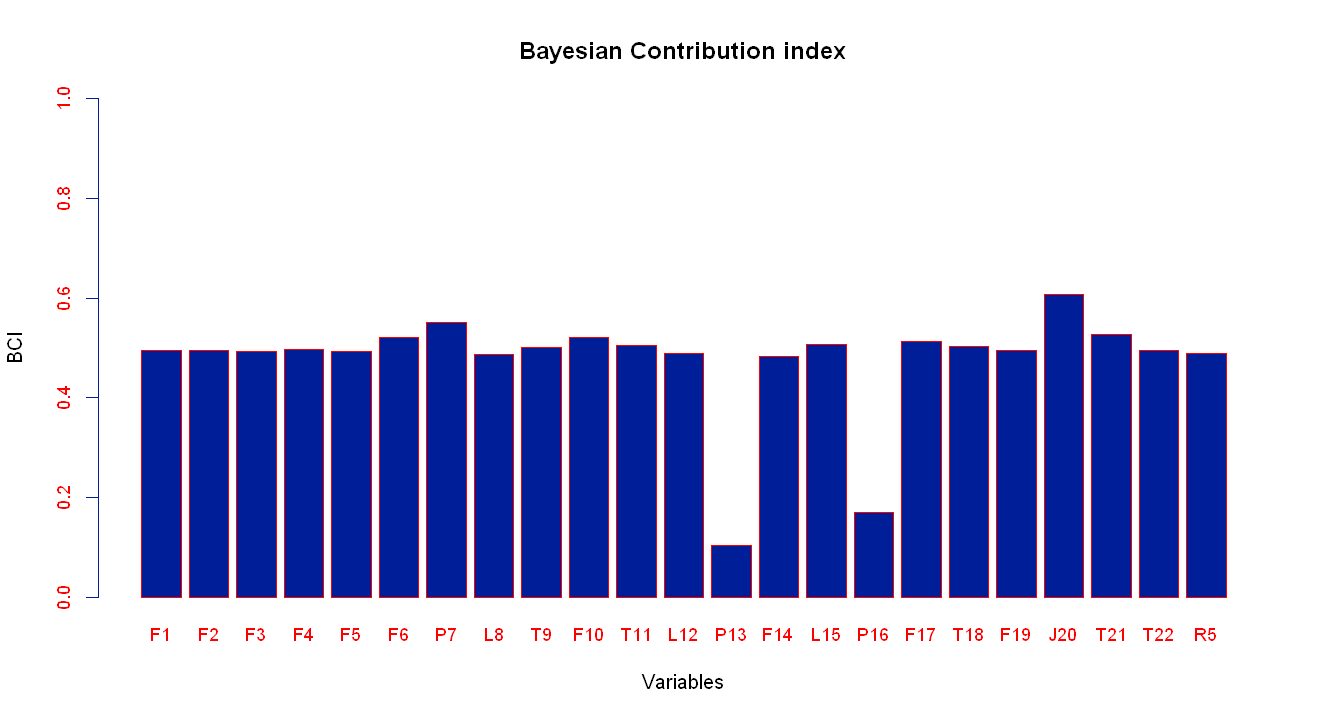

In [174]:
bci_16a = BCI(gaussian_total1, "default16", 161, 160)
bci_16a

BCI_plot(bci_16a)

<hr>

<span style="color:green"><font size="5"><b>[IDV16] Obtained</b></font></span> 

Fault Occured at 161


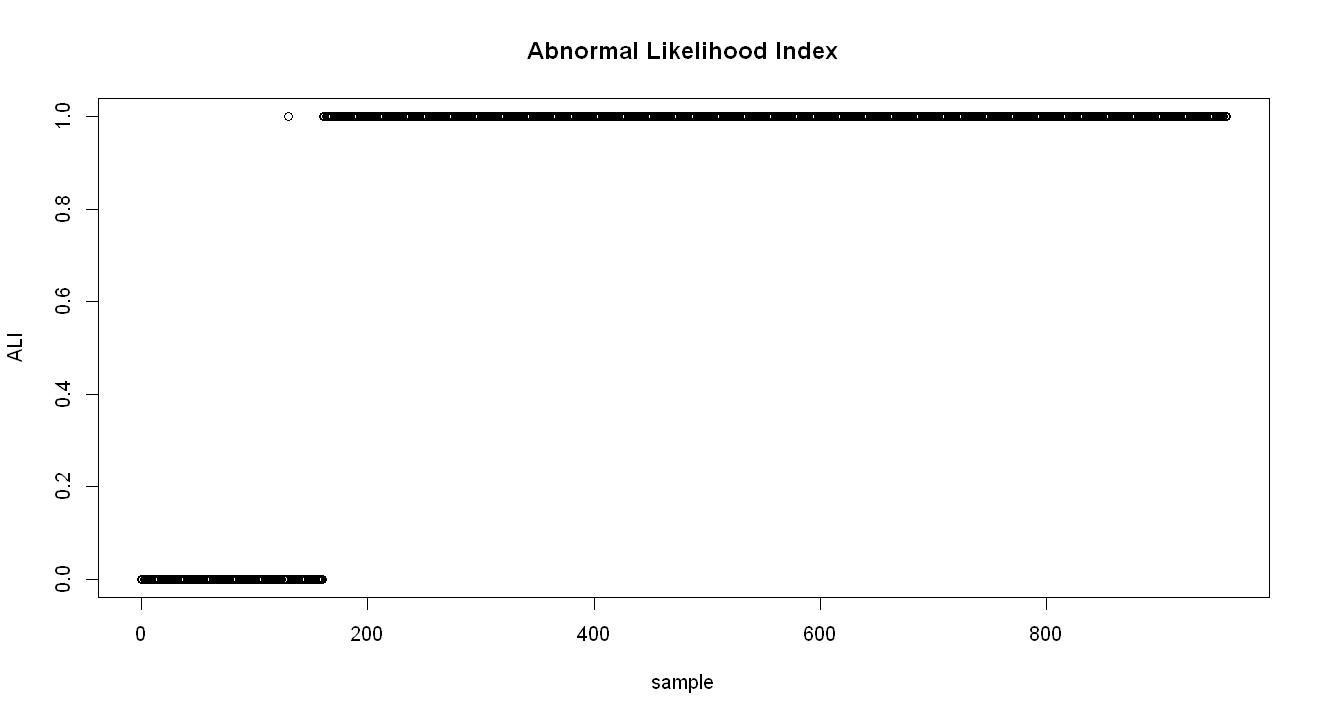

In [175]:
ALI(gaussian_total2, "16")

Warning message in if (class(bn.fit) != "bn.fit") {:
"the condition has length > 1 and only the first element will be used"

F1,F2,F3,F4,F5,F6,P7,L8,T9,F10,...,F14,L15,P16,F17,T18,F19,J20,T21,T22,R5
0.4950855,0.4940164,0.4924965,0.4975459,0.4927013,0.5202141,0.5614153,0.4868836,0.496151,0.5213549,...,0.48294,0.5044016,0.1735043,0.518605,0.538062,0.5007837,0.6035154,0.4886673,0.5011232,0.4889572


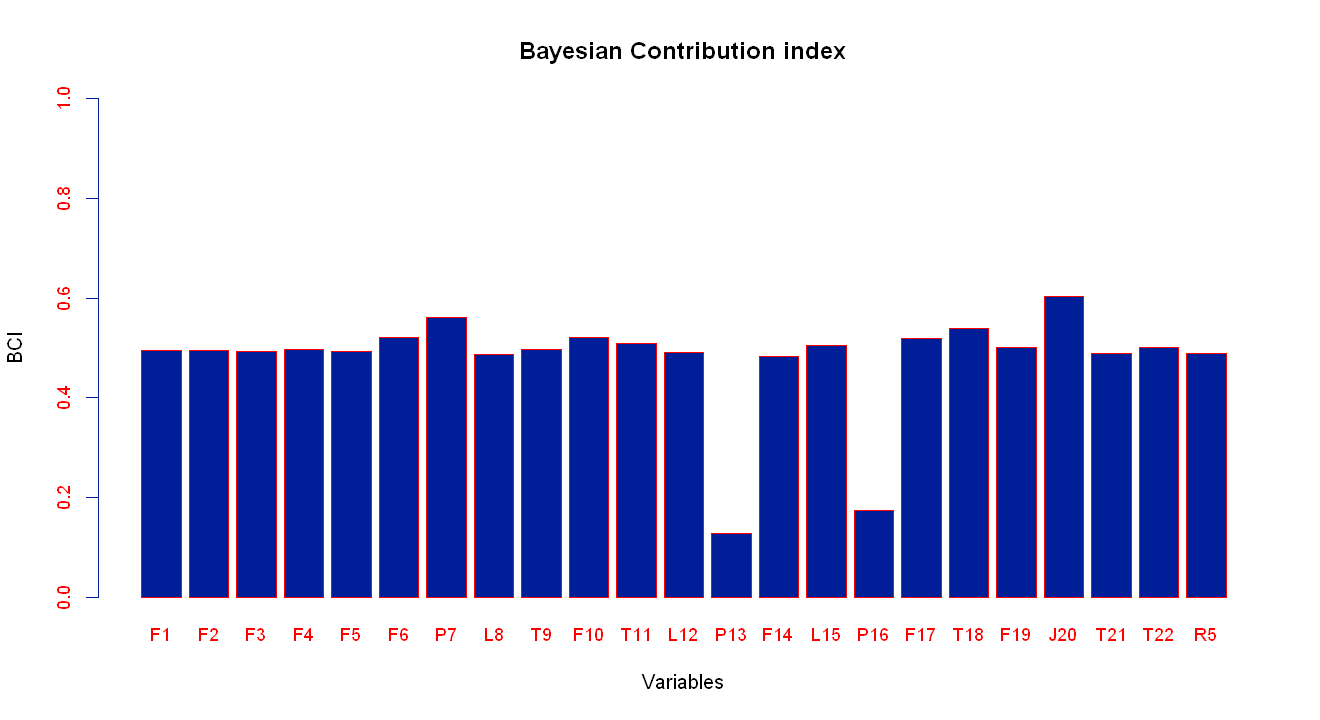

In [176]:
bci_16 = BCI(gaussian_total2, "default16", 161, 160)
bci_16

BCI_plot(bci_16)

<hr>

<hr>